### 编辑人:苏则茜
### Project:Prob-Na-Learning
+ WBI行为数据分析：时间轴对齐，运动参数提取
+ 数据裁剪，数据拼接

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import os
import csv
import cv2
from scipy.ndimage import label
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.ndimage import grey_opening,grey_closing
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
# 设置字体为 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
def cut_and_draw(df, n, alg_spd = 1, CTX = 0, speed = 0,turn=1, reorientation=1):
    # 将轨迹分段可视化
    df_idx_list = np.arange(0, len(df), n)   # 切数据
    for i, idx in enumerate(df_idx_list[:-1]):
        df_d = df.loc[idx: df_idx_list[i+1], :]
        plt.figure()
        plt.scatter(df_d.X,df_d.Y, s=0.8,c = df_d.Time, cmap='jet')
        ax = plt.gca()
        plt.title(f'idx{idx}')
        plt.colorbar(label='Time(s)')
        ax.set_aspect(1)
        plt.show()
        
        if alg_spd:
            #画角速度
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.agl_speed, cmap='jet')
            plt.title(f'idx{idx} agl_speed')
            plt.colorbar(ax1, label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.agl_speed)
            plt.show()
        if CTX:
            # 画CTX
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.CTX_left, cmap='jet')
            plt.title(f'idx{idx} CTX')
            plt.colorbar(ax1, label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.CTX_left)
            ax[1].set_title('CTX_left distribution')
            plt.show()
        if speed:
            # 画速度
            fig, ax = plt.subplots(1,2)
            ax1 = ax[0].scatter(df_d.X,df_d.Y, s=0.8,c = df_d.speed, cmap='jet')
            plt.title(f'idx{idx} agl_speed')
            plt.colorbar(ax1,label='Time(s)')
            ax[0].set_aspect(1)
            ax[1].hist(df_d.speed)
            ax[1].set_title('speed distribution')
            plt.show()
        if reorientation:
            fig, ax = plt.subplots(1,2)
            ax[1].scatter(df_d.X, df_d.Y, c = 'grey',s=0.8, alpha=0.05)
            ax[0].scatter(df_d.X, df_d.Y, c = 'grey',s=0.8, alpha=0.05)
            df_pt = df_d[df_d.Reorientation==1]
            df_tn = df_d[df_d.Event==1]
            ax[0].scatter(df_tn.X, df_tn.Y, s = 0.8, c='r')
            ax[1].scatter(df_pt.X, df_pt.Y, s = 0.8, c='r')
            ax[0].set_title('Sharp turn')
            ax[1].set_title('Reorientation')
            plt.show()

In [3]:
# 速度，角速度，bearing angle, Dist_to_center, ctx计算函数
# 输入：筛选为虫子的csv文件，画圆的csv文件，ID索引，速度平滑，角速度速度平滑，角速度平滑，追踪帧率，跳帧数量，像素长度
def Sliding_CTX_calation(df_worms, grad_vec,sm_inv, spd_sm_inv, hlf_sm_inv,window_size = 20, frame_rate = 20, track_jump_frame = 1):
    # 只适用于线性梯度，因为CTX只计算到左和右边缘的
    # 速度平滑窗s sm_inv
    # 计算角速度的速度平滑窗s spd_sm_inv
    # 角速度平滑床s hlf_sm_inv
    
    # ======================================数据平滑=================
    # 1. 移动窗口平滑
    # 对X和Y坐标进行移动平均
    df_slide = df_worms.copy()
    df_slide['X'] = df_slide['X'].rolling(window=window_size, center=True).mean()
    df_slide['Y'] = df_slide['Y'].rolling(window=window_size, center=True).mean()

    # ======================================速度计算=================
    
    
    # 根据帧率计算半平滑窗，但是具体计算速度和角速度的时间根据时间戳来确定
    print(sm_inv, frame_rate, track_jump_frame)
    half_bins_spd = int((sm_inv*frame_rate)//track_jump_frame)
    bins_spd = 2*half_bins_spd

    trajectory_0 = df_slide[['X','Y','Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[bins_spd:]-x[:len(x)-bins_spd])                       # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[bins_spd:]-y[:len(y)-bins_spd])
    time_step = trajectory_1[:,2] 
    print('time_step', time_step)
    time_step_vec = time_step[bins_spd:]-time_step[:len(time_step)-bins_spd]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    print('平均时间间隔'+str(np.average(time_step_vec))+'应该等于总平滑窗'+str(sm_inv*2))
    mean_time_inv = np.average(time_step_vec)   # 平均时间间隔
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]      # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((half_bins_spd,2),np.nan)
    nan_bin_spd = np.full((half_bins_spd,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))                  # 速度向量
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))                        # 速率向量
    
    df_idx = df_slide[['X','Y','Time']].copy()      
    df_idx['speed'] = pd.Series(speed[:,0],index = df_idx.index)                    # 将speed和velocity加入dataframe
    df_idx['x_velocity'] = pd.Series(velocity[:,0],index = df_idx.index)
    df_idx['y_velocity'] = pd.Series(velocity[:,1],index = df_idx.index)
    
    # ======================================================角速度计算===========

    half_bins_spd_agl = int((spd_sm_inv*frame_rate)//track_jump_frame)
    bins_spd_agl = 2*half_bins_spd_agl                                 # 角速度速度平滑窗
    hlf_agl_bins = int((hlf_sm_inv*frame_rate)//track_jump_frame)      # 角速度半平滑窗
    print('角速度半平滑窗：', hlf_agl_bins)
    trajectory_0 = df_slide[['X','Y','Time']].values      # 提取x,y坐标和时间戳
    trajectory_1 = (trajectory_0.copy()).astype('float')                            # 转float数据类型
    x = trajectory_1[:,0]
    y = trajectory_1[:,1]
    delta_x = (x[bins_spd_agl:]-x[:len(x)-bins_spd_agl])                                     # 得到减去头尾数据点的delta_x和delta_y
    delta_y = (y[bins_spd_agl:]-y[:len(y)-bins_spd_agl])
    time_step = trajectory_1[:,2]   
    time_step_vec = time_step[bins_spd_agl:]-time_step[:len(time_step)-bins_spd_agl]        # 得到减去头尾数据点的对应delta-x和delta-y的时间
    velocity_bef = np.dstack((delta_x/time_step_vec,delta_y/time_step_vec))[0]             # 使用dstack函数合并x,y方向计算的速度为一个矩阵
    speed_bef = np.linalg.norm(velocity_bef, axis = 1).reshape(-1,1)
    nan_bin_vec = np.full((half_bins_spd_agl,2),np.nan)
    nan_bin_spd = np.full((half_bins_spd_agl,1),np.nan)
    velocity = np.vstack((nan_bin_vec, velocity_bef, nan_bin_vec))
    speed = np.vstack((nan_bin_spd, speed_bef, nan_bin_spd))[:,0]
    time_step_vector = np.vstack((nan_bin_spd, time_step_vec.reshape(-1,1), nan_bin_spd))[:,0]
    
    df_speed_cal = pd.DataFrame(speed,columns = ['speed'])              # 生成一个包含speed的df并提取索引
    
    idx_vec = df_speed_cal.index                                        # 生成索引列表时先掐头去尾再取非零值
    df_washed_speed = df_speed_cal[half_bins_spd_agl:len(idx_vec)-half_bins_spd_agl]
    idx_nz_vec = df_washed_speed[df_washed_speed['speed']!=0].index     # 索引是相对于总长度，但是这个列表中直接去掉了头尾速度为nan的和速率为0的点的索引
    df_speed_cal['agl_velocity'] = pd.Series([np.nan]*len(idx_vec))

    for i in range(hlf_agl_bins,len(idx_nz_vec)-hlf_agl_bins):
        n = hlf_agl_bins
        agl_i = clws_delta_phi(velocity[idx_nz_vec[i-n]],velocity[idx_nz_vec[i+n]]) 
        time_end= time_step[idx_nz_vec[i+n]]
        time_start = time_step[idx_nz_vec[i-n]]
        delta_t_i = time_end-time_start
#         print("timestamp", time_start, time_start)
#         print('角度计算时间间隔：',delta_t_i)
        agl_vel_i = agl_i/delta_t_i

        if np.isnan(agl_vel_i) == False:
            df_speed_cal['agl_velocity'].loc[idx_nz_vec[i]] = agl_vel_i
        else:
#             print(velocity[idx_nz_vec[i-n]],velocity[idx_nz_vec[i+n]])
            df_speed_cal['agl_velocity'].loc[idx_nz_vec[i]] = 0 
    # 将angular_velocity和angular_speed加入dataframe(df_idx)
    df_idx['agl_velocity'] = pd.Series(df_speed_cal['agl_velocity'].values,index = df_idx.index)
    df_idx.loc[:,'x_velocity_agl'] = velocity[:,0]
    df_idx.loc[:,'y_velocity_agl'] = velocity[:,1]
    df_idx.loc[df_idx.speed == 0, 'agl_velocity'] = 0                 # 将speed为0的点角速度设为0
    df_idx['agl_speed'] = np.abs(df_idx['agl_velocity'])
    
    # ===========================================计算CTX=====================================
    vec_left = grad_vec
    vel_vec = df_idx[['x_velocity','y_velocity']].values
    bearing_left = []
    
    ctxs = []
    for i in range(len(vel_vec)):
        agl_i_left = clws_delta_phi(vec_left,vel_vec[i,:])
        agl_i_left = agl_i_left/180*np.pi     # bearing angle使用的是弧度制
        bearing_left.append(agl_i_left)                                      # 使用弧度制
        
        vel_vec_i = vel_vec[i,:]
        ctx_i = -vel_vec_i[0]/np.sqrt(vel_vec_i[0]**2+vel_vec_i[1]**2)
        ctxs.append(ctx_i)
        
    df_idx['CTX_left'] = pd.Series(ctxs, index = df_idx.index)
    df_idx['bearing_left'] = pd.Series(bearing_left, index = df_idx.index)
#     df_idx['CTX_left']=df_idx['bearing_left'].apply(np.cos,axis = 0)
    df_idx['X_org'] = df_worms['X']                     # 将平滑前的轨迹也加入df
    df_idx['Y_org'] = df_worms['Y']


    return df_idx

In [4]:
def Label_Pirouettes_by_id(g_df,t_crit=6.16, frame_rate = 30,min_agl_spd=None):
# 输入：同一个id的df, t_crit(sec)，如果需要重新分turn可以输入min_agl_spd
# 注意输入的df中不能是不同组混合的，id必须独立
    t_f_crit = t_crit*frame_rate
    if min_agl_spd:
        g_df.loc[:,'Event']=0
        g_df.loc[g_df.agl_speed >= min_agl_spd, 'Event']=1
        
    g_df.loc[:,'Reorientation']=g_df['Event']
    g_df = g_df.reset_index(drop=True)
    # nan值是计算速度和角速度时舍弃的点，默认是0不计算c
    event_vec = g_df.Event.fillna(0).values

    # 向后移动一位，上下相减
    diff_vec = event_vec[1:]-event_vec[:-1]
    if (diff_vec==0).all():
        pass
    elif ~(diff_vec==-1).any() or ~(diff_vec==1).any():
        print('只有结尾有turn或只有开头有turn')
    else:
        # 统计所有出现1和-1的索引
        idx_1 = np.where(diff_vec == 1)[0]
        idx_n1 = np.where(diff_vec == -1)[0]
        if np.min(idx_1)<np.min(idx_n1):
            # 如果最小的索引是1而不是-1，说明开头是run，然后才开始出现turn
            if len(idx_1)>len(idx_n1):
                # 如果1的数量大于-1,说明最后一个turn没有结束
#                 print(f'验证最后是否以turn结束:{(np.max(idx_n1)<np.max(idx_1))}')
                # 去掉第一个1的索引，用1减去所有-1的索引，判断长度
                run_lens_btw_turns = idx_1[1:]-idx_n1
                for i,r in enumerate(run_lens_btw_turns):
                    if r <= t_f_crit:
                        low_b = idx_n1[i]+1
                        upper_b = idx_1[i+1]+1      # 注意idx_1去头，所以索引内加以
                        g_df.loc[low_b:upper_b, 'Reorientation']=1

            elif len(idx_1)==len(idx_n1):
                # 如果两者数量相同，说明最后以run结尾，这条轨迹前后是完整的多个turn
#                 print(f'验证最后是否以run结束:{(np.max(idx_n1)>np.max(idx_1))}')
                # 去掉1的所索引的首部和-1的尾部，用1减去-1的索引判断长度
                run_lens_btw_turns = idx_1[1:]-idx_n1[:-1]
                for i,r in enumerate(run_lens_btw_turns):
                    if r <= t_f_crit:
                        low_b = idx_n1[i]+1
                        upper_b = idx_1[i+1]+1
                        g_df.loc[low_b:upper_b, 'Reorientation']=1

            # 无论是上述哪种情况，turn的数量都记为出现1的数量
            num_turn = len(idx_1)
#             print(f'Turn number: {num_turn}')
        elif np.min(idx_1)>np.min(idx_n1):
            # 如果最小索引是-1而不是1，说明开头就是turn
            if (len(idx_n1)== len(idx_1)+1):
                # 如果-1比1多一个，说明以run结尾
#                 print(f'验证最后是否以run结束:{(np.max(idx_n1)>np.max(idx_1))}')
                # 去掉最后一个-1的索引，用1减去-1
                run_lens_btw_turns = idx_1-idx_n1[:-1]
                for i,r in enumerate(run_lens_btw_turns):
                    if r <= t_f_crit:
                        low_b = idx_n1[i]+1
                        upper_b = idx_1[i]+1
                        g_df.loc[low_b:upper_b, 'Reorientation']=1
            elif (len(idx_n1) == len(idx_1)):
                # 如果-1和1一样多，说明以turn结尾
#                 print(f'验证最后是否以turn结束:{(np.max(idx_n1)<np.max(idx_1))}')
                # 直接用1的索引减去-1
                run_lens_btw_turns = idx_1-idx_n1
                for i,r in enumerate(run_lens_btw_turns):
                    if r <= t_f_crit:
                        low_b = idx_n1[i]+1
                        upper_b = idx_1[i]+1
                        g_df.loc[low_b:upper_b, 'Reorientation']=1
    return g_df

In [5]:
# 定义角度计算公式
def ang_cal(vec_1,vec_2):
    dot_pro = np.dot(vec_1, vec_2)
    mod_1 = np.sqrt(np.dot(vec_1,vec_1))
    mod_2 = np.sqrt(np.dot(vec_2,vec_2)) 
    if mod_1 == 0 or mod_2 ==0:
        angle = 0
    else:
        cos = dot_pro/(mod_1*mod_2)
        if np.isnan(cos) == True:
            angle = np.nan
        else:  
            angle = np.arccos(round(cos,1))  #弧度制
    return angle

def clws_delta_phi(vec_1, vec_2, vec_0 = [1,0]):
    # vec_1 is the first vector, and it rotates to the vec_2
    vec_0 = np.array(vec_0)
    agl_1 = ang_cal(vec_1,vec_2)
    agl_2 = ang_cal(vec_0, vec_1)
    agl_3 = ang_cal(vec_0, vec_2)
    if agl_1 == 0:
        agl_1 = 0
        # print('angle = 0°')
    elif agl_1 == np.pi:
        agl_1 = np.pi
        # print('angle = 180°')
    elif vec_1[1] >= 0 and vec_2[1] >= 0:    #同时在第一第二象限
        if (agl_3 - agl_2) > 0:
            agl_1 = (-1)*np.abs(agl_1)
        else:
            agl_1 = np.abs(agl_1)
    elif vec_1[1] <= 0 and vec_2[1] <= 0:    #同时在第三第四象限
        if (agl_3 - agl_2) > 0:
            agl_1 = np.abs(agl_1)
        else:
            agl_1 = (-1)*np.abs(agl_1)
    elif vec_1[1] >= 0 and vec_2[1] <= 0:
        if (agl_3 + agl_2) > np.pi:
            agl_1 = (-1)*np.abs(agl_1)
        else:                                  #如果等于180°认为是顺时针旋转
            agl_1 = np.abs(agl_1)
    elif vec_1[1] <= 0 and vec_2[1] >= 0:
        if (agl_3 + agl_2) < np.pi:
            agl_1 = (-1)*np.abs(agl_1)
        else:                                  #如果等于180°认为是顺时针旋转
            agl_1 = np.abs(agl_1)   
    return agl_1*180/np.pi

In [6]:
def Insert_SharpTurn(df_als, min_agl = 50, max_agl = 110):
    print('=======================开始事件分类===================================')
    print('注：事件分类仅完成分类（turn = 1, run = 0），tunrning rate的计算较为灵活，在汇总分析作图时使用')
    # 新建一列为Event
    if 'Event' in df_als:
        df_als = df_als.drop('Event', axis = 1)
    df_als['Event'] = np.nan
    # 选择角速度区间
    # sharp turn 标记为1
    df_als.loc[(np.abs(df_als.agl_velocity)>= min_agl)&(np.abs(df_als.agl_velocity) <= max_agl), 'Event'] = 1  
    # run 标记为0
    df_als.loc[(np.abs(df_als.agl_velocity) < min_agl), 'Event'] = 0
    return df_als

In [7]:
def Scatter_Pirouette(df, folder = '', x_lim = []):
    fig,ax = plt.subplots(1,1)
    plt.scatter(df.X, df.Y, c = 'grey',s=0.8, alpha=0.05)
    df_pt = df[df.Reorientation==1]
    plt.scatter(df_pt.X, df_pt.Y, s = 0.8, c='r')
    plt.title('Reorientation')
    if len(x_lim):
        plt.xlim(*x_lim)
    ax.set_aspect(1)
    if folder:
        fig.savefig(folder+'Visual_Reorientation.png')
    else:
        plt.show()

In [8]:
def Scatter_Pos_Grad_Dir(df, Pos_CTX_vec, scale_size = 2, folder = '', x_lim=[]):
    fig,ax = plt.subplots(1,1)
    
    mean_x = df.X.mean()
    mean_y = df.Y.mean()
    origin = [mean_x, mean_y]
    vector = np.array(Pos_CTX_vec)*scale_size
    
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy',
               scale=1, color='k', label='Pos_CTX_vec')
#     # 在指定位置标注向量值
#     vector_ctr = np.array([mean_x+0.5*vector[0], mean_y+0.5*vector[0]])
#     print(vector_ctr)
#     position = vector_ctr + np.array([0, 1])
#     print('Position', position)
#     plt.text(position[0], position[1], f"{Pos_CTX_vec}", fontsize=8, color='k')
    plt.legend()
    plt.scatter(df.X,df.Y, s=0.8,c = df.Time, cmap='jet')
    ax = plt.gca()
    plt.colorbar(label='Time(s)')
    
    if len(x_lim):
        plt.xlim(*x_lim)
    ax.set_aspect(1)
    if folder:
        fig.savefig(folder+'Pos-Grad-Dir.png')
    else:
        plt.show()

In [26]:
def Align_timestamp(file_folder):
    '''
    输入track文件夹，读取时间戳和运动数据文件，输出对齐后的数据
    '''
    file_name = file_folder + '\\'
    videoFile = file_name + 'c1.mp4'
    data_stage = pd.read_csv(file_name + 'stage_data.txt', header = None).values
    t_stage =  data_stage[:, 0]
    f_data = np.loadtxt(file_name + 'c1.txt', delimiter=',')
    t_c = f_data[f_data[:,3] == 1, 1]

    x = data_stage[:, 3] / 1000
    y = data_stage[:, 4] / 1000

    # 计算速度
    dx = np.diff(x)
    dy = np.diff(y)
    T = data_stage[:, 0] / 1000
    dt = np.diff(T)
    v = np.sqrt(dx ** 2 + dy ** 2) / dt
    v_m = np.convolve(v, np.ones(60)/60, mode='same')
    
    # 可视化追踪和激光照射的时间比例
    figure1, ax1 = plt.subplots(2,1, figsize = (6,10))
    ax1[0].scatter(T[1:], v_m, 1)
    ax1[0].set_title('可视化激光照射和总追踪时长',fontsize = 10, pad =10)
    ax1[0].tick_params(axis = 'both', labelsize = 7.5)
    ax1[1].set_aspect('equal', adjustable='box')
#     ax1[1].set_title('可视化激光照射区间轨迹', fontsize = 10, pad = 10)
    ax1[1].tick_params(axis = 'both', labelsize = 7.5)
    ax1[1].scatter(x, y, 1)
    
    # 计算激光照射时间
    s_data = pd.read_csv(file_name + 'laser-data.txt', header = None)
    s_start = s_data[s_data[1] == 2].index
    s_stop = s_data[s_data[1] == 3].index
    if s_stop.empty:
        s_s = [len(s_data[1])]
        print(s_s)
    else:
        s_s = []
        for m in s_start:
            data = (s_stop >= m)
            s_s.append(s_stop[data == 1][0])
    for i in range(len(s_start)):
        t_array = []
        t_l = int(round((s_data[0][s_start[i] + 1 : s_s[i] - 1]).diff().sum(skipna=True) / (s_s[i] - s_start[i] - 2)))
        t = s_data[0].values
        t_frame = np.concatenate([[t[s_start[i]] - t_l *2, t[s_start[i]] - t_l], t[s_start[i]:s_s[i]]])
        t_start = s_data[0][s_start[i]] - t_l *2
        t_stop = s_data[0][s_s[i] - 1] + t_l

        data1 = t_stage > t_start
        
        id_start = np.where(data1 == 1)[0][0] - 1
        data1 = t_stage > t_stop
#         print('data1',data1)
#         print(np.where(data1 == 1))
        # 找到首次t_stage>t_stop的索引
        id_stop_series = np.where(data1 == 1)[0]
        if len(id_stop_series):
            id_stop = id_stop_series[0]
        else:
            print('请检查track是否在激光之后关闭')
            id_stop = len(data1)-1
        np.savetxt(file_name + 's' + str(i + 1) + '.txt', data_stage[id_start:id_stop, [0,3,4]] / 1000, fmt='%.4f')
        np.savetxt(file_name + 't' + str(i + 1) + '.txt', t_frame / 1000, fmt='%.4f')
        ax1[0].scatter(T[id_start:id_stop], v_m[id_start:id_stop], 1)
        ax1[1].scatter(x[id_start:id_stop], y[id_start:id_stop], 1)

        data1 = t_c > t_start
        id_start = np.where(data1 == 1)[0][0] - 1
        f_start = id_start.astype(str)
        data1 = t_c > t_stop
        
        id_stop_series = np.where(data1 == 1)[0]
        if len(id_stop_series):
            id_stop = id_stop_series[0]
            f_stop = id_stop.astype(str)
        else:
            print('请检查track是否在激光之后关闭')
            id_stop = len(data1)-1
            f_stop = str(id_stop)
        
        with open(file_name + 'f' + str(i + 1) + '.txt', 'a') as file:
            file.write('Start:\n')
            file.write(f_start)
            file.write('\n')
            file.write('Stop:\n')
            file.write(f_stop)

    # 显示图形
#     figure1.savefig(file_name + 'VisualTimePeriodLaserOn.jpg')
    ax1[1].scatter(x[0], y[0], 15, c='green')
    ax1[1].scatter(x[-1], y[-1], 15, c='red')

In [27]:
def Realign_coordinate(p_f, df_motion): 
    '''
    2025.2.27：目前stage calibrate设置原点在右下角，这个代码将原点根据四个标定点重新设为左上角。
    另外根据x轴轨迹做镜面翻转
    '''
    
    # 初始化
    df_ul = pd.DataFrame({})
    df_ur = pd.DataFrame({})
    df_ll = pd.DataFrame({})
    df_lr = pd.DataFrame({})
    files = [f for f in os.listdir(p_f) if '.txt' in f ]
    for f in files:
        if 'upper_left' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ul = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ul) == 1:
                df_ul.index = ['upper_left']
            else:
                print('upper_left标记数量不对')
        if 'upper_right' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ur = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ur) == 1:
                df_ur.index = ['upper_right']
            else:
                print('upper_right标记数量不对')
        if ('lower_left' in f) :
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_ll = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_ll) == 1:
                df_ll.index = ['lower_left']
            else:
                print('lower_left标记数量不对')
        if 'lower_right' in f:
            # 运动参数位置文件
            column_names = [ 'X', 'Y']
            df_lr = pd.read_csv(os.path.join(p_f, f),sep=r',', header=None, names=column_names)
            if len(df_lr) == 1:
                df_lr.index = ['lower_right']
            else:
                print('lower_right标记数量不对')

    df_label = pd.concat([df_ul, df_ll, df_ur, df_lr])
    df_label['X'] = df_label['X'].astype(float)/1000
    df_label['Y'] = df_label['Y'].astype(float)/1000
    # 调整x坐标(平移y轴)
    x_min = (df_label.loc['upper_left','X'] + df_label.loc['lower_left','X'])/2
    x_max = (df_label.loc['upper_right','X'] + df_label.loc['lower_right','X'])/2
    if x_min > x_max:
        # 如果原点在高钠一侧，则需要减去left的坐标后将X坐标值变号
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        df_motion_r['X'] = -df_motion_r['X']
    else:
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        
    # 调整y轴坐标，平移x轴  (另外y轴会和原坐标翻转)
    y_min = (df_label.loc['lower_left','Y'] + df_label.loc['lower_right','Y'])/2
    y_max = (df_label.loc['upper_left','Y'] + df_label.loc['upper_right','Y'])/2
    
    if y_min > y_max:
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
    else:
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
        df_motion_r1['Y'] = -df_motion_r1['Y']
    return df_label, df_motion_r1

In [28]:
def Realign_coordinate_false(p_f, df_motion): 
    '''
     手动设置四个角的坐标
    '''
    upper_left = [64000, 32000]
    upper_right = [24000, 32000]
    lower_left = [64000, 0]
    df_label['X'] = df_label['X'].astype(float)/1000
    df_label['Y'] = df_label['Y'].astype(float)/1000
    # 调整x坐标(平移y轴)
    x_min = upper_left[0]
    x_max = upper_right[0]
    if x_min > x_max:
        # 如果原点在高钠一侧，则需要减去left的坐标后将X坐标值变号
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        df_motion_r['X'] = -df_motion_r['X']
    else:
        df_motion_r = df_motion.copy()
        df_motion_r['X'] = df_motion_r['X']-x_min
        
    # 调整y轴坐标，平移x轴  (另外y轴会和原坐标翻转)
    y_min = lower_left[1]
    y_max = upper_left[1]
    
    if y_min > y_max:
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
    else:
        df_motion_r1 = df_motion_r.copy()
        df_motion_r1['Y'] = df_motion_r1['Y']-y_max
        df_motion_r1['Y'] = -df_motion_r1['Y']
    return df_label, df_motion_r1

In [29]:
def map_color_dict(key_items,color_map='tab10'):
    '''
    # 提前生成统一的color_dict()
    # color(根据dates元素的数量分配，输出以key_items元素(可以是condition或dates)为key的颜色映射字典)
    '''
    
    color_vec_norm = np.linspace(0.01,0.99,len(key_items)+1)
    colormap = mpl.colormaps[color_map]
    colors  = colormap(color_vec_norm)
    color_dict = {}
    for i, d in enumerate(key_items):
        color_dict[d] = colors[i]
    return color_dict

In [30]:
def set_time_intervals(df, time_len, time_inv, time_col='Vol_Time'):
    """
    设置时间间隔并为 DataFrame 添加时间段标签。
    时间列单位为s，不需要frame_rate

    Parameters:
    - df: 输入 DataFrame，需包含 'Timestamp' 列。
    - time_len: 总时间长度（小时）。
    - time_inv: 时间间隔（分钟）。

    Returns:
    - 更新后的 DataFrame，添加了 'Period_label' 列。
    - 时间段标签列表。
    """
    periods = np.arange(0, time_len + 1, time_inv)
    labels = [(periods[i] + periods[i + 1]) / 2 for i in range(len(periods) - 1)]
    df['Period_label'] = pd.cut(
        df[time_col], bins=periods, labels=labels, right=False, include_lowest=True
    )
    return df, labels

导入文件处理

# 导入时间戳和位置txt文件处理为csv

In [31]:
# 输入每一对txt文件所在的的文件夹

file_path_all = r'Z:\data space+\C. elegans chemotaxis\20250609_WBI'
# 包含所有荧光数据的文件夹（没有则不加）
file_path_fluo = r''
folder_beh_label = ''    # 行为标记文件夹名称
file_path_beh_label = os.path.join(file_path_all, folder_beh_label)

根据行为数据记录原始文件，依次进行：
+ 对齐stage, camera, fluorescent imaging时间轴
+ 根据位置坐标序列抽取运动参数，输出MotionExtract文件（待裁剪/拼接）
+ 根据volume timestamp对齐神经数据时间和位置序列时间，将行为参数列和从calcium_trace.npy的神经活动迹合并到单个文件NeuralAlignMotion中
    (如果暂时没有calcium可以选择不合并)



=======开始处理20250609_lg9624-1gNa-002-23.5d-ov_004中文件，
包含:['c1.txt', 'c2.txt', 'focus_data.txt', 'laser-data.txt', 'lower_left.txt', 'lower_right.txt', 'stage_data.txt', 'tracking_data.txt', 'upper_left.txt', 'upper_right.txt']
读取运动参数文件
读取volume时间戳文件
22586
0.5 50.00000000000995 1
time_step [ 41.793  41.813  41.833 ... 755.755 755.775 755.795]
平均时间间隔1.044297732731853应该等于总平滑窗1.0
角速度半平滑窗： 50
日期:20250609, 编号：004
 Conditions:['lg9624', '1gNa', '002', '23.5d', 'ov']
写出抽取的运动参数文件到:20250609_lg9624-1gNa-002-23.5d-ov_004/20250609_lg9624-1gNa-002-23.5d-ov_004_MotionExtract.csv
写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:20250609_lg9624-1gNa-002-23.5d-ov_004/20250609_lg9624-1gNa-002-23.5d-ov_004_NeuralAlignMotion.csv


=======开始处理20250609_lg9624-1gNa-002-24d-ov_003中文件，
包含:['c1.txt', 'c2.txt', 'focus_data.txt', 'laser-data.txt', 'lower_left.txt', 'lower_right.txt', 'stage_data.txt', 'tracking_data.txt', 'upper_left.txt', 'upper_right.txt']
读取运动参数文件
读取volume时间戳文件
351
0.5 49.99999999976126 1
time_step [ 46.148  46.1

C:\Users\Windows11\AppData\Local\Temp\ipykernel_24452\4220207809.py:110: RuntimeWarning: invalid value encountered in scalar divide
  ctx_i = -vel_vec_i[0]/np.sqrt(vel_vec_i[0]**2+vel_vec_i[1]**2)


日期:20250609, 编号：003
 Conditions:['lg9624', '1gNa', '002', '24d', 'ov']
写出抽取的运动参数文件到:20250609_lg9624-1gNa-002-24d-ov_003/20250609_lg9624-1gNa-002-24d-ov_003_MotionExtract.csv
写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:20250609_lg9624-1gNa-002-24d-ov_003/20250609_lg9624-1gNa-002-24d-ov_003_NeuralAlignMotion.csv
20250609_lg9624-1gNa-002-24d-ov_005中缺少数据处理必须的文件如下：
upper_left.txt
lower_left.txt
upper_right.txt
lower_right.txt


=======开始处理20250609_lg9624-1gNa-002-24d-ov_007中文件，
包含:['c1.txt', 'c2.txt', 'focus_data.txt', 'laser-data.txt', 'lower_left.txt', 'lower_right.txt', 'stage_data.txt', 'tracking_data.txt', 'upper_left.txt', 'upper_right.txt']
读取运动参数文件
读取volume时间戳文件
36581
0.5 49.99999999997442 1
time_step [ 28.89   28.91   28.936 ... 934.568 934.589 934.608]
平均时间间隔1.0377479150237772应该等于总平滑窗1.0
角速度半平滑窗： 49
日期:20250609, 编号：007
 Conditions:['lg9624', '1gNa', '002', '24d', 'ov']
写出抽取的运动参数文件到:20250609_lg9624-1gNa-002-24d-ov_007/20250609_lg9624-1gNa-002-24d-ov_007_MotionExtract.csv
写出与神经数据时间戳(不包含钙数据)对应的运动参数

KeyError: 'upper_left'

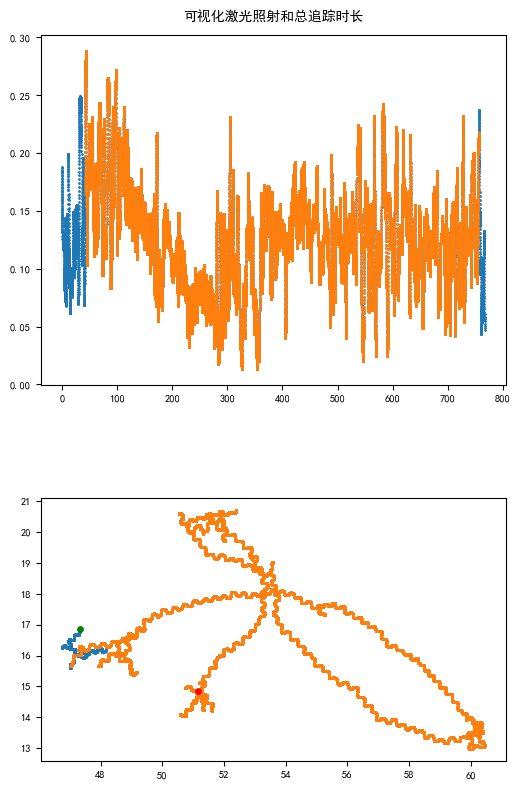

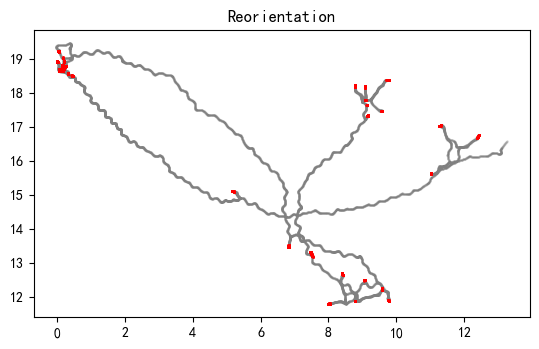

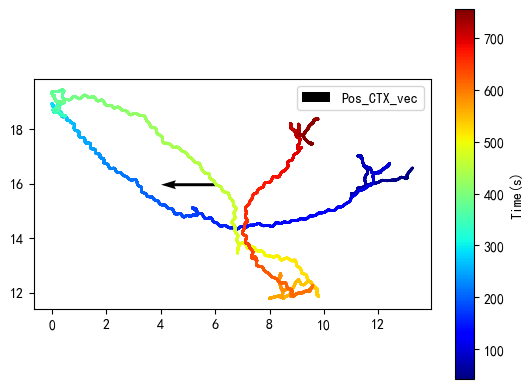

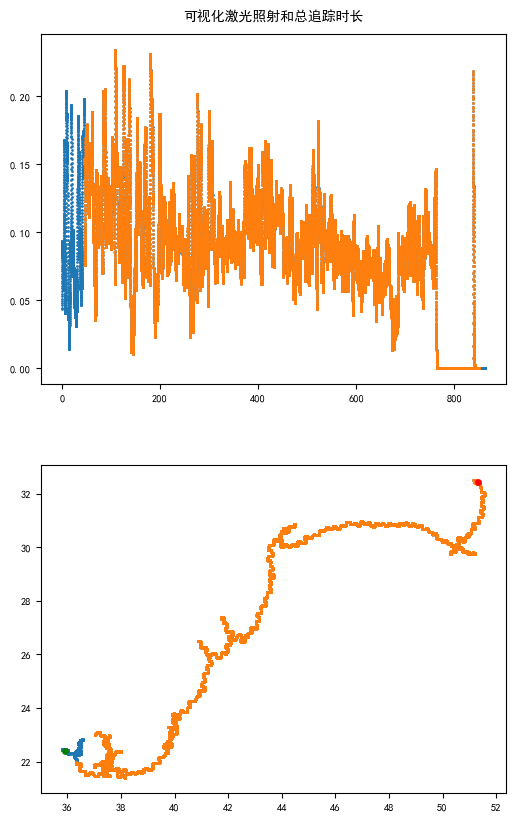

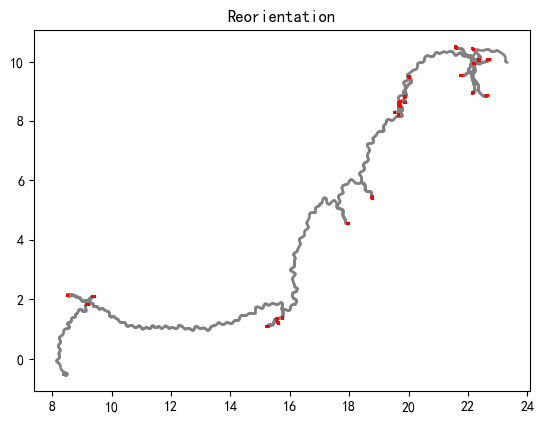

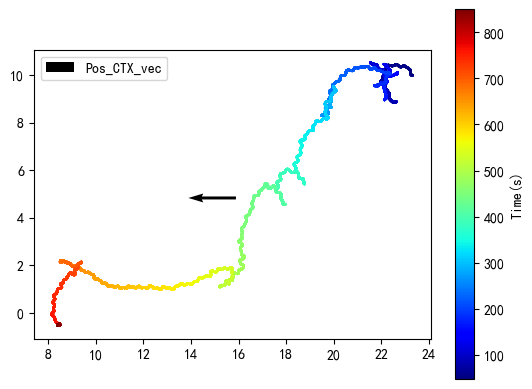

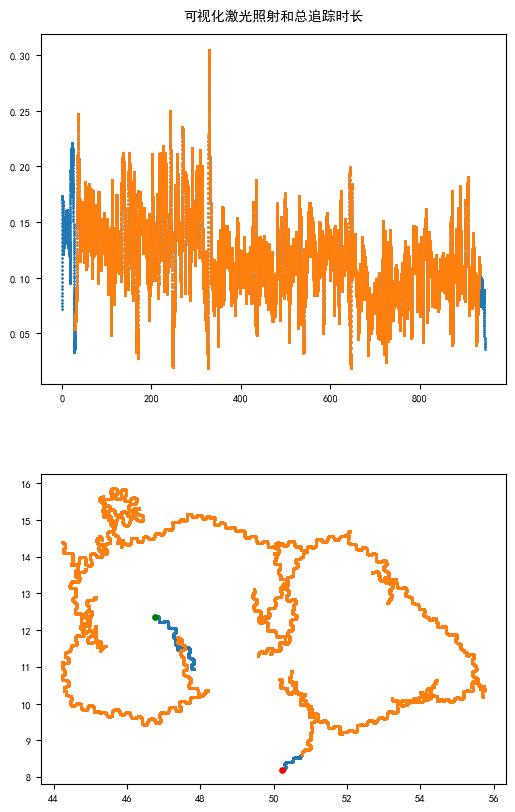

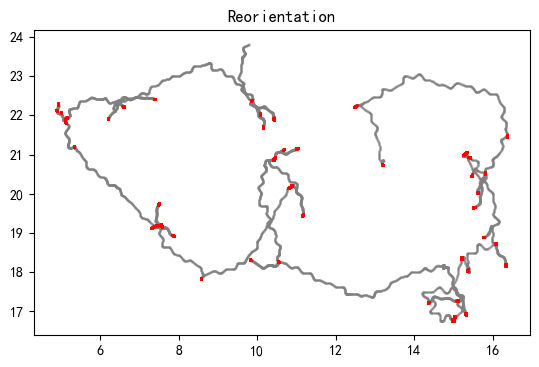

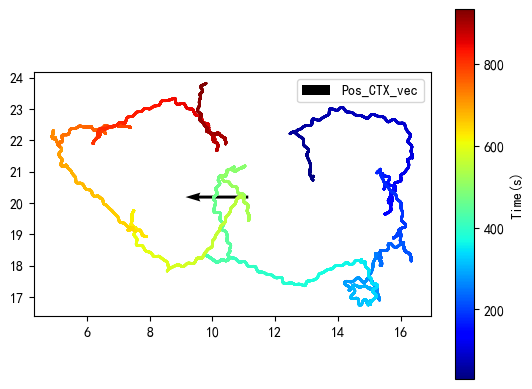

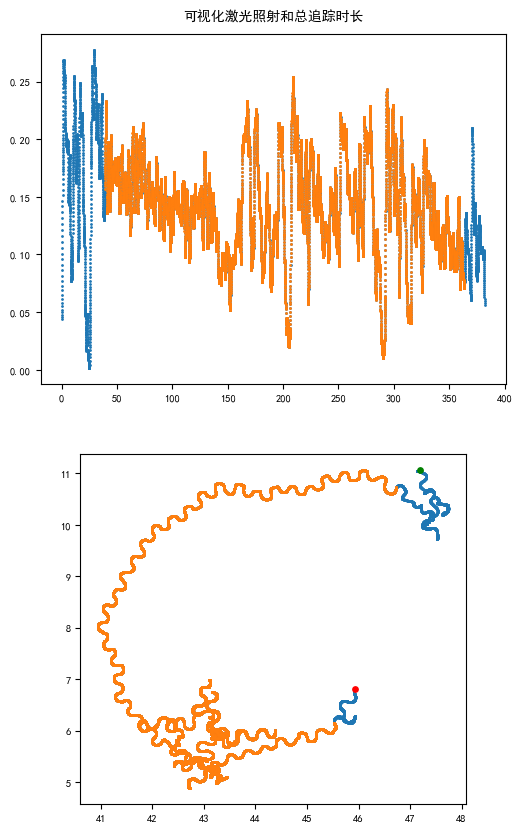

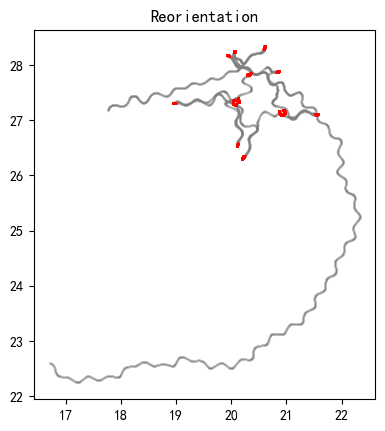

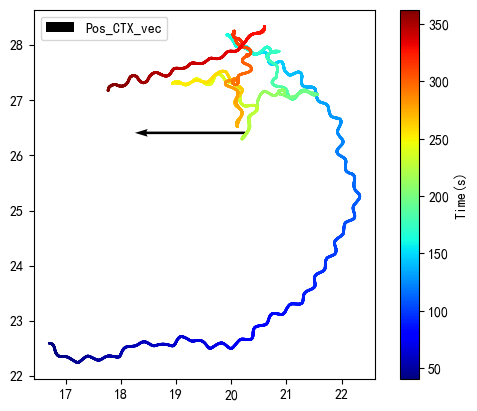

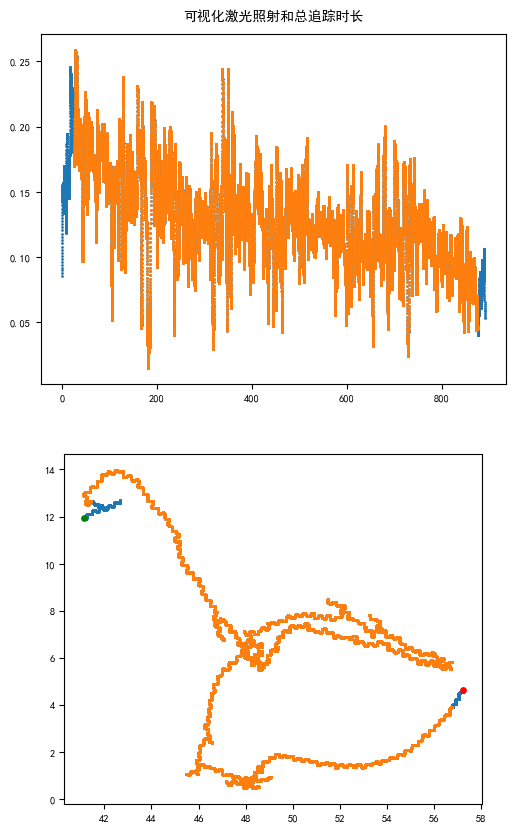

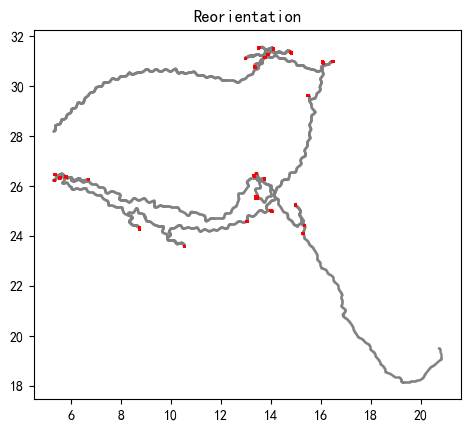

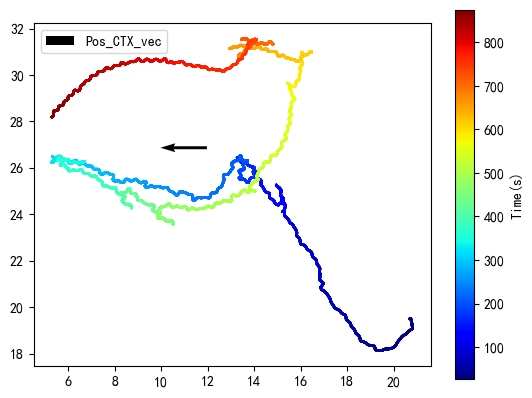

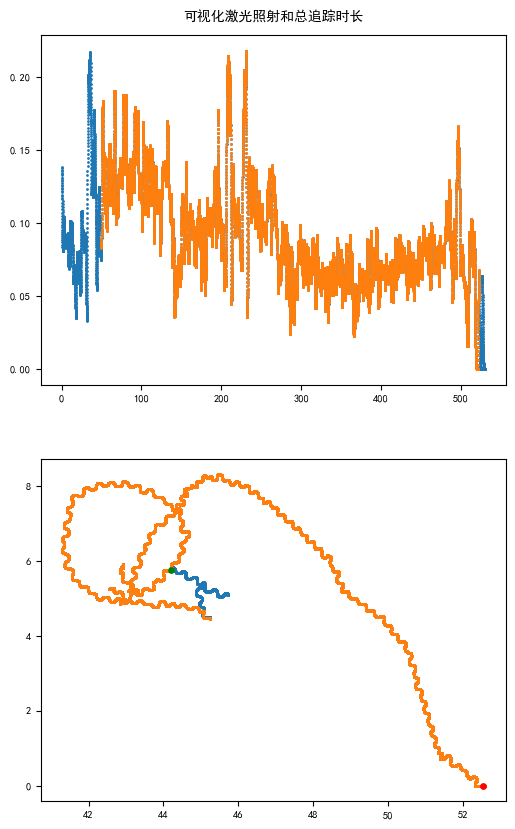

In [32]:
# 放入所有包含单个实验文件的文件夹

position_file_names  = ['s1']
vol_time_file_names = ['t1']

# position_file_names = ['s1', 's1', 's2', 's1', 's1']
# vol_time_file_names = ['t1','t1','t2','t1','t1'] 

required_files = ['stage_data.txt', 'c1.txt','laser-data.txt',
                 'upper_left.txt', 'lower_left.txt', 'upper_right.txt',
                 'lower_right.txt']   # 数据处理需要的文件
required_files_set = set(required_files)

key_word = ''
write = True    # 是否写出文件
hlf_spd_inv = 0.5
hlf_agl_spd_inv = 0.2
hlf_agl_inv = 1
Pos_CTX_vec = [-1,0]
t_crit = 3.8
min_agl_spd = 75
cut_window = 2000
half_width = 20  #mm 琼脂片宽度的一半



file_paths = [os.path.join(file_path_all,f_p) for f_p in os.listdir(file_path_all) if ('trash' not in f_p)&
              ('done' not in f_p)&
             os.path.isdir(os.path.join(file_path_all,f_p))&
             (key_word in f_p)]

for i, p_f in enumerate(file_paths):
    df_motion = {}
    df_vol_time = {}
    calcium = True   # 默认有荧光信号的所有文件都包含钙信号
    files = [f for f in os.listdir(p_f) if '.txt' in f ]
    # 转化为集合进行比较
    files_set = set(files)
    # 判断文件夹中的文件是否完全包含自定义列表中的元素
    is_contained = required_files_set.issubset(files_set)
    # 找出missing_files
    missing_files = [file for file in required_files if file not in files]
    
    if is_contained:
        print(f'\n\n=======开始处理{os.path.basename(os.path.normpath(p_f))}中文件，\n包含:{files}')
        # 预处理：时间戳对齐
        Align_timestamp(p_f)
        files = [f for f in os.listdir(p_f) if '.txt' in f ]
        for f in files:
            if (len(position_file_names)==1):
                if position_file_names[0] in f:
                    # 运动参数位置文件
                    print('读取运动参数文件')
                    column_names = ['Time', 'X', 'Y']
                    df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
                                            names=column_names)
                    df_motion = df_motion.astype(float)

                    # 转换坐标，统一x轴坐标起点为0，终点为4.5
                    df_label, df_motion = Realign_coordinate(p_f, df_motion)
                    # 打印轨迹
                elif vol_time_file_names[0] in f:
                    # volume时间戳文件
                    print('读取volume时间戳文件')
                    column_names = ['Vol_Time']
                    df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)

            elif (len(position_file_names)>1):
                if position_file_names[i] in f:
                    # 运动参数位置文件
                    column_names = ['Time', 'X', 'Y']
                    df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)
                    df_motion = df_motion.astype(float)

                    # 转换坐标，统一x轴坐标起点为0，终点为4.5
                    df_label, df_motion = Realign_coordinate(p_f, df_motion)
                    # 打印轨迹


                elif vol_time_file_names[i] in f:
                    # volume时间戳文件
                    column_names = ['Vol_Time']
                    df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)


        # 查找在motion.Time中最近值和索引，加入df_vol_time中
        nearest_times = []
        nearest_indices = []
        for vol_time in df_vol_time['Vol_Time']:
            # 计算时间差的绝对值
            differences = np.abs(df_motion['Time'] - vol_time)
            # 找到最小差值的索引
            nearest_idx = np.argmin(differences)
            # 保存最近时间值和索引
            nearest_times.append(df_motion.loc[nearest_idx, 'Time'])
            nearest_indices.append(nearest_idx)

        # 将结果存入 DataFrame
        df_vol_time['Nearest_Time'] = nearest_times
        df_vol_time['Nearest_Index'] = nearest_indices


        # 根据运动位置信息抽取运动参数
        
#         plt.hist()
#         plt.title('df_motion Time')
#         plt.show()
        mean_frame_rate = np.median(1/np.diff(df_motion.Time.values))
        print(np.argmin(np.diff(df_motion.Time.values)))
        
        df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
                                          window_size=100, frame_rate=mean_frame_rate)
        df_motion_pt = Label_Pirouettes_by_id(df_motion_als, t_crit=t_crit, min_agl_spd=min_agl_spd)
        # visualization check
        Scatter_Pirouette(df_motion_pt, folder=p_f+'\\')
        Scatter_Pos_Grad_Dir(df_motion_pt, Pos_CTX_vec, folder=p_f+'\\')
    #     cut_and_draw(df_motion_pt, n = cut_window)

        # 将df_motionz中的运动参数按照索引对应到神经数据时间戳上
        columns_to_add = ['X', 'Y', 'speed', 'agl_speed', 'CTX_left', 'Event', 'Reorientation']
        for col in columns_to_add:
            df_vol_time[col] = df_vol_time['Nearest_Index'].map(df_motion_pt[col])

        # 加入condition
        folder_name = os.path.basename(os.path.normpath(p_f))
        features = folder_name.split('_')
        df_motion_pt['Date'] = features[0]
        df_vol_time['Date'] = features[0]
        df_motion_pt['Rep_id'] = features[-1]
        df_vol_time['Rep_id'] = features[-1]
        condition_ls = features[-2].split('-')
        print(f'日期:{features[0]}, 编号：{features[-1]}\n Conditions:{condition_ls}')
        for i, c in enumerate(condition_ls):
            if len(condition_ls) > 1:
                con_col = 'Condition'+str(i)
                df_motion_pt[con_col] = c
                df_vol_time[con_col] = c
            else:
                df_motion_pt['Condition'] = features[-2]
                df_vol_time['Condition'] = features[-2]
        if len(condition_ls) > 1:
            df_vol_time['Date_Con_Rep'] = features[-2]

        df_motion_pt['Disp_to_mid'] = df_motion_pt['X']-half_width
        df_vol_time['Disp_to_mid'] = df_vol_time['X']-half_width
        if file_path_fluo:
            # 如果有神经数据的地址，就加上
            # 加入神经数据
            # 用于寻找神经数据
            f = os.path.basename(p_f)
            f_decom_name = f.split("_")
            f_date = f_decom_name[0]
            f_idx  = f_decom_name[-1]

            cal_path = os.path.join(file_path_fluo, f_idx)
            files = list(Path(cal_path).rglob("calcium_intensity.npy"))
            if not files:
                calcium = False
                print("未找到任何 calcium_trace.npy 文件。")
            elif len(files)>1:
    
                print("找到以下文件：")
                for i, file in enumerate(files):
                    print(f"{i}: {file}")

                index = int(input(f"请输入要读取的文件索引 (0~{len(files) - 1}): "))

                if 0 <= index < len(files):
                    selected_file = files[index]
                    calcium_intensity = np.load(selected_file)
                    print(f"成功加载: {selected_file}")
                else:
                    print("输入索引无效！")
            else:
                calcium_intensity= np.load(files[0])
            if calcium:
                print('处理前文件大小:neuron*timestamp',calcium_intensity.shape)
                # 将神经数据与行为数据合并
                calcium_intensity_T = calcium_intensity.T
                # 创建列名
                col_neuron_names = [f"{i+1}" for i in range(calcium_intensity_T.shape[1])]
                df_calcium = pd.DataFrame(calcium_intensity_T, columns=col_neuron_names)
                # 按照行索引合并
                df_cal_motion = pd.concat([df_calcium, df_vol_time], axis=1)

                # 写出文件
                if write:
                    # folder_name为当前数据日期批次
                    fn_motion_output = folder_name+'_MotionExtract.csv'
                    df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
                    print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
                    fn_nt_output = folder_name+'_NeuralAlignMotionCal.csv'
                    df_cal_motion.to_csv(os.path.join(p_f, fn_nt_output), index = False)
                    print(f'写出与神经数据时间戳(包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
            else:
                # 没有找到钙信号
                if write:
                    # folder_name为当前数据日期批次
                    fn_motion_output = folder_name+'_MotionExtract.csv'
                    df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
                    print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
                    fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
                    df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
                    print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
        else:
            # 写出文件
            if write:
                # folder_name为当前数据日期批次
                fn_motion_output = folder_name+'_MotionExtract.csv'
                df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
                print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
                fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
                df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
                print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
    else:
        print(f'{os.path.basename(os.path.normpath(p_f))}中缺少数据处理必须的文件如下：\n' + "\n".join(missing_files))
        continue

### 数据裁剪
+ 对于追丢的数据，需要裁剪追踪丢失时间点前的数据作为最终数据

In [16]:
# 包含同一天数据的大文件夹
file_path_beh = r'Z:\data space+\C. elegans chemotaxis\20250410_WBI\track'
# # 包含所有荧光数据的文件夹
# file_path_fluo = r'D:\data analysis\fluorescent'
# 裁剪文件夹名称和裁剪时段(s)按顺序摆放
file_to_slice = ['20250410_1g-ov-24d_001'
                ]
idx_end = [4250]

write = True

print('检查文件数量和idx_ls数量是否相同：', len(idx_end)==len(file_to_slice))
for i in range(len(idx_end)):
    print(f"{file_to_slice[i]}:{idx_end[i]}\n")
for i,f in enumerate(file_to_slice):
    print(f'=======开始处理文件{f}====================')
    f_p = os.path.join(file_path_beh, f)
    
    f_mot = f+'_MotionExtract.csv'
    df_mot = pd.read_csv(os.path.join(f_p, f_mot))
    file_contain_cal = [file for file in os.listdir(os.path.join(file_path_beh, f)) if '_NeuralAlignMotionCal' in file]
    if len(file_contain_cal):
        f_neu = f+'_NeuralAlignMotionCal.csv'
    else:
        f_neu = f+'_NeuralAlignMotion.csv'
    df_neu = pd.read_csv(os.path.join(f_p, f_neu))
    print(f'原本NeuralAlignMotion文件的时间跨度为:{df_neu.Vol_Time.min()}~{df_neu.Vol_Time.max()}')
    df_neu_slice = df_neu.loc[:idx_end[i], :]
    print(f'裁剪后NeuralAlignMotion文件的时间跨度：{df_neu_slice.Vol_Time.min()}~{df_neu_slice.Vol_Time.max()}')
    nearest_time = df_neu.loc[idx_end[i], 'Nearest_Time']
    print(f'原本MotionExtract文件的时间跨度为:{df_mot.Time.min()}~{df_mot.Time.max()}')
    df_mot_slice = df_mot[df_mot.Time <= nearest_time]
    print(f'裁剪后MotionExtract文件的时间跨度：{df_mot_slice.Time.min()}~{df_mot_slice.Time.max()}')
    
#     # 用于寻找神经数据
#     f_decom_name = f.split("_")
#     f_date = f_decom_name[0]
#     f_idx  = f_decom_name[-1]
    
#     cal_path = os.path.join(file_path_fluo, f_date, f_idx)
#     cal_int= np.load(os.path.join(cal_path, 'calcium_intensity.npy'))
#     print('处理前文件大小:neuron*timestamp',cal_int.shape)
#     cal_int_slice = cal_int[:,:idx_end[i]]
#     print('处理后:neuron*timestamp',cal_int_slice.shape)
    
    if write:
          f_mot_new = f+'_MotionExtract_slice.csv'
          df_mot_slice.to_csv(os.path.join(f_p, f_mot_new), index = False)
          f_neu_new = f+'_NeuralAlignMotion_slice.csv'
          df_neu_slice.to_csv(os.path.join(f_p, f_neu_new), index = False)
print('裁剪处理完成>.<\n======================================')
#           cal_new =" calcium_intensity_slice.npy"
#           np.save(os.path.join(cal_path,cal_new), cal_int_slice)

检查文件数量和idx_ls数量是否相同： True
20250410_1g-ov-24d_001:4250

=======开始处理文件20250410_1g-ov-24d_001====================


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\data space+\\C. elegans chemotaxis\\20250410_WBI\\track\\20250410_1g-ov-24d_001\\20250410_1g-ov-24d_001_MotionExtract.csv'

### 数据拼接
+ 对于行为状态良好，但是意外追丢的线虫可能会重开继续追，将多段数据根据时间关系拼接在一起
+ 先抽运动参数再拼接
+ 思路：根据两个运动数据文件的创建时间差加上后一个文件的原时间戳

In [ ]:
# 大文件夹装有待拼接的文件
file_path_all = r'Z:\data space+\C. elegans chemotaxis\20250409_WBI'
# 根据时序关系放置
file_to_concat = ['20250409_1g-ov-24d_012', '20250409_1g-ov-24d_013']

write = True

ctimes = []
for i, f_n in enumerate(file_to_concat):
    # 获取每个文件夹中state_data的创建时间
    f_p = os.path.join(file_path_all,f_n)
    stage_data_i = os.path.join(f_p, 'stage_data.txt')
    ctimes.append(os.stat(stage_data_i).st_ctime)    # 创建时间（s）
    
# 计算每个数据与第一个数据stage_data创建时间的时间差
# 计算时间差，保留两位小数（0.01秒）
time_diff_ls  = []
for i, f_n in enumerate(file_to_concat):
    print(f_n)
    time_dff_i = round(abs(ctimes[i] - ctimes[0]), 3)
    time_diff_ls.append(time_dff_i)
    f_path = os.path.join(file_path_all, f_n)
    f_slice_ls = [f for f in os.listdir(f_path) if ('_slice.csv' in f)]
    if len(f_slice_ls):
        # 如果有切片文件，使用切片文件
        f_mot = [f for f in os.listdir(f_path) if ('MotionExtract_slice.csv' in f)][0]
        f_neu = [f for f in os.listdir(f_path) if ('NeuralAlignMotion_slice.csv' in f)][0]
    else:
        f_mot = [f for f in os.listdir(f_path) if ('MotionExtract.csv' in f)][0]
        f_neu = [f for f in os.listdir(f_path) if ('NeuralAlignMotion.csv' in f)][0]

    df_mot = pd.read_csv(os.path.join(f_path, f_mot))
    df_neu = pd.read_csv(os.path.join(f_path, f_neu))

    df_mot['Time'] = df_mot['Time'] + time_dff_i
    df_neu['Vol_Time'] = df_neu['Vol_Time']+ time_dff_i
    df_neu['Nearest_Time'] = df_neu['Nearest_Time']+ time_dff_i

    if write:
        print('写出文件')
        # 写出运动参数文件
        mot_name_new = f_mot.replace("MotionExtract", 'MotionExtract_mod')
        df_mot.to_csv(os.path.join(f_path, mot_name_new), index = False)
        # 写出对齐神经数据时间戳的运动参数文件
        neu_name_new = f_neu.replace("NeuralAlignMotion", 'NeuralAlignMotion_mod')
        df_neu.to_csv(os.path.join(f_path, neu_name_new), index = False)

print(f"验证文件创建时间差:{time_diff_ls}")
print(f'=====拼接多个文件======')

folder_output = os.path.join(file_path_all, file_to_concat[0])    # 选择拼接文件输出的文件夹，一般设置为第一个片段

# 运动数据
key_word = 'MotionExtract_mod.csv'
df_to_concat = []
rep_ids = []
for i, f_p in enumerate(file_to_concat):
    f_path = os.path.join(file_path_all,f_p)
    # 收集所有需要concat的数据路径
    f_path_to_concat_i  = [os.path.join(f_path, f) for f in os.listdir(f_path) if key_word in f][0]
    df_i = pd.read_csv(f_path_to_concat_i)
#     if i == 0:
    # 取第一个文件的编号作为rep_id
    rep_id_i = df_i.Rep_id.unique()[0]
    rep_ids.append(rep_id_i)
    df_to_concat.append(df_i)
df_concat = pd.concat(df_to_concat, ignore_index=True)
df_concat['Rep_id'] = rep_ids[0]
print(f'拼接后使用同一个Rep_id:{rep_ids[0]}')
if write:
    idx_exp_first = '-'.join(map(str, rep_ids[1:]))
    concat_name = file_to_concat[0]+'-'+idx_exp_first+'_MotionExtract_concat.csv'
    df_concat.to_csv(os.path.join(folder_output,concat_name), index = False)
    
# 神经配准数据
key_word = 'NeuralAlignMotion_mod.csv'
df_to_concat = []
rep_ids = []
for i, f_p in enumerate(file_to_concat):
    f_path = os.path.join(file_path_all,f_p)
    # 收集所有需要concat的数据路径
    f_path_to_concat_i  = [os.path.join(f_path, f) for f in os.listdir(f_path) if key_word in f][0]
    df_i = pd.read_csv(f_path_to_concat_i)
    df_i['Old_index'] = df_i.index
    rep_id_i = str(df_i.Rep_id.unique()[0])
    rep_ids.append(rep_id_i)
    df_to_concat.append(df_i)
    
# 拼接时保留index
df_concat = pd.concat(df_to_concat, ignore_index = False)

# 取第一个文件的编号作为rep_id
df_concat['Rep_id'] = rep_ids[0]
print(f'拼接后使用同一个Rep_id:{rep_ids[0]}')
if write:
    # 修改部分
    idx_exp_first = '-'.join(map(str, rep_ids[1:]))  # 将 rep_ids 中的元素转换为字符串类型=
    concat_name = file_to_concat[0]+'-'+idx_exp_first+'_NeuralAlignMotion_concat.csv'
    df_concat.to_csv(os.path.join(folder_output,concat_name), index = False)

### 特殊数据处理
+ 对于缺少标定点的文件，可跳过对齐坐标轴的步骤只处理文件本身


In [ ]:

# 特殊文件文件夹地址
p_f = r'Z:\data space+\C. elegans chemotaxis\20250312_WBI\20250312_4.5g-24d-4.5h_006'


position_file_names  = ['s1']
vol_time_file_names = ['t1']

required_files = ['stage_data.txt', 'c1.txt','track_data.txt',
                 ]   # 数据处理需要的文件
required_files_set = set(required_files)
write = True    # 是否写出文件
hlf_spd_inv = 0.5
hlf_agl_spd_inv = 0.2
hlf_agl_inv = 1
Pos_CTX_vec = [-1,0]
t_crit = 3.8
min_agl_spd = 75
cut_window = 2000
half_width = 20  #mm 琼脂片宽度的一半


calcium = True   # 默认有荧光信号的所有文件都包含钙信号
files = [f for f in os.listdir(p_f) if '.txt' in f ]
# 转化为集合进行比较
files_set = set(files)
# 判断文件夹中的文件是否完全包含自定义列表中的元素
is_contained = required_files_set.issubset(files_set)
# 找出missing_files
missing_files = [file for file in required_files if file not in files]

if is_contained:
    print(f'\n\n=======开始处理{os.path.basename(os.path.normpath(p_f))}中文件，\n包含:{files}')
    # 预处理：时间戳对齐
    Align_timestamp(p_f)
    for f in files:
        if (len(position_file_names)==1):
            if position_file_names[0] in f:
                # 运动参数位置文件
                print('读取运动参数文件')
                column_names = ['Time', 'X', 'Y']
                print(os.path.join(p_f, f))
                df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
                                        names=column_names)
                df_motion = df_motion.astype(float)

                # 转换坐标，统一x轴坐标起点为0，终点为4.5
                df_label, df_motion = Realign_coordinate_false(p_f, df_motion)
                # 打印轨迹
            elif vol_time_file_names[0] in f:
                # volume时间戳文件
                print('读取volume时间戳文件')
                column_names = ['Vol_Time']
                print(os.path.join(p_f, f))
                df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)
    # 查找在motion.Time中最近值和索引，加入df_vol_time中
    nearest_times = []
    nearest_indices = []
    for vol_time in df_vol_time['Vol_Time']:
        # 计算时间差的绝对值
        differences = np.abs(df_motion['Time'] - vol_time)
        # 找到最小差值的索引
        nearest_idx = np.argmin(differences)
        # 保存最近时间值和索引
        nearest_times.append(df_motion.loc[nearest_idx, 'Time'])
        nearest_indices.append(nearest_idx)

    # 将结果存入 DataFrame
    df_vol_time['Nearest_Time'] = nearest_times
    df_vol_time['Nearest_Index'] = nearest_indices


    # 根据运动位置信息抽取运动参数

    mean_frame_rate = np.mean(1/np.diff(df_motion.Time.values))
    df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
                                      window_size=100, frame_rate=mean_frame_rate)
    df_motion_pt = Label_Pirouettes_by_id(df_motion_als, t_crit=t_crit, min_agl_spd=min_agl_spd)
    # visualization check
    Scatter_Pirouette(df_motion_pt, folder=p_f+'\\')
    Scatter_Pos_Grad_Dir(df_motion_pt, Pos_CTX_vec, folder=p_f+'\\')
#     cut_and_draw(df_motion_pt, n = cut_window)

    # 将df_motionz中的运动参数按照索引对应到神经数据时间戳上
    columns_to_add = ['X', 'Y', 'speed', 'agl_speed', 'CTX_left', 'Event', 'Reorientation']
    for col in columns_to_add:
        df_vol_time[col] = df_vol_time['Nearest_Index'].map(df_motion_pt[col])

    # 加入condition
    folder_name = os.path.basename(os.path.normpath(p_f))
    features = folder_name.split('_')
    df_motion_pt['Date'] = features[0]
    df_vol_time['Date'] = features[0]
    df_motion_pt['Rep_id'] = features[-1]
    df_vol_time['Rep_id'] = features[-1]
    condition_ls = features[-2].split('-')
    print(f'日期:{features[0]}, 编号：{features[-1]}\n Conditions:{condition_ls}')
    for i, c in enumerate(condition_ls):
        if len(condition_ls) > 1:
            con_col = 'Condition'+str(i)
            df_motion_pt[con_col] = c
            df_vol_time[con_col] = c
        else:
            df_motion_pt['Condition'] = features[-2]
            df_vol_time['Condition'] = features[-2]
    if len(condition_ls) > 1:
        df_vol_time['Date_Con_Rep'] = features[-2]

    df_motion_pt['Disp_to_mid'] = df_motion_pt['X']-half_width
    df_vol_time['Disp_to_mid'] = df_vol_time['X']-half_width
    if file_path_fluo:
        # 如果有神经数据的地址，就加上
        # 加入神经数据
        # 用于寻找神经数据
        f = os.path.basename(p_f)
        f_decom_name = f.split("_")
        f_date = f_decom_name[0]
        f_idx  = f_decom_name[-1]

        cal_path = os.path.join(file_path_fluo, f_idx)
        files = list(Path(cal_path).rglob("calcium_intensity.npy"))
        if not files:
            calcium = False
            print("未找到任何 calcium_trace.npy 文件。")
        elif len(files)>1:

            print("找到以下文件：")
            for i, file in enumerate(files):
                print(f"{i}: {file}")

            index = int(input(f"请输入要读取的文件索引 (0~{len(files) - 1}): "))

            if 0 <= index < len(files):
                selected_file = files[index]
                calcium_intensity = np.load(selected_file)
                print(f"成功加载: {selected_file}")
            else:
                print("输入索引无效！")
        else:
            calcium_intensity= np.load(files[0])
        if calcium:
            print('处理前文件大小:neuron*timestamp',calcium_intensity.shape)
            # 将神经数据与行为数据合并
            calcium_intensity_T = calcium_intensity.T
            # 创建列名
            col_neuron_names = [f"{i+1}" for i in range(calcium_intensity_T.shape[1])]
            df_calcium = pd.DataFrame(calcium_intensity_T, columns=col_neuron_names)
            # 按照行索引合并
            df_cal_motion = pd.concat([df_calcium, df_vol_time], axis=1)

            # 写出文件
            if write:
                # folder_name为当前数据日期批次
                fn_motion_output = folder_name+'_MotionExtract.csv'
                df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
                print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
                fn_nt_output = folder_name+'_NeuralAlignMotionCal.csv'
                df_cal_motion.to_csv(os.path.join(p_f, fn_nt_output), index = False)
                print(f'写出与神经数据时间戳(包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
        else:
            # 没有找到钙信号
            if write:
                # folder_name为当前数据日期批次
                fn_motion_output = folder_name+'_MotionExtract.csv'
                df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
                print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
                fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
                df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
                print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
    else:
        # 写出文件
        if write:
            # folder_name为当前数据日期批次
            fn_motion_output = folder_name+'_MotionExtract.csv'
            df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
            print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
            fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
            df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
            print(f'写出与神经数据时间戳(不包含钙数据)对应的运动参数文件到:{folder_name}/{fn_nt_output}')
else:
    print(f'{os.path.basename(os.path.normpath(p_f))}中缺少数据处理必须的文件如下：\n' + "\n".join(missing_files))

可视化手动标注行为

In [ ]:
# 提取所有行为文件csv，进行时间戳对齐
f_b_l_ls = [f for f in os.listdir(file_path_beh_label) if '_beh' in f]
for f in f_b_l_ls:
    df_b = pd.read_csv(os.path.join(file_path_beh_label, f))
    f_name = os.path.basename(f)
    f_num = f_name.split('_')[0]
    print(f'处理文件编号：{f_num}')
    
    # 在主文件夹中找到对应编号子文件夹，提取tracking文件创建时间
    p_track_f = [os.path.join(file_path_all, f) for f in os.listdir(file_path_all) if
                 (f_num in f)&(os.path.isdir(os.path.join(file_path_all,f)))]
    c_time = os.path.getctime(p_track_f[0])
    file_creation_datetime = pd.to_datetime(datetime.fromtimestamp(c_time))
    df_b['Time'] = pd.to_datetime(df_b['Time'])
    df_b['Time_diff'] = df_b['Time'] - file_creation_datetime
    df_b['Time_diff_sec'] = df_b['Time_diff'].dt.total_seconds()
    print(f'文件{f_name}的首个记录时间为{df_b.loc[0,"Time"]},\n减去stage_data创建时间{file_creation_datetime}为{df_b.loc[0,"Time_diff_sec"]}')
    # 写入文件编号为新列
    df_b['Rep_id'] = f_num
    df_b['Rep_id'] = df_b['Rep_id'].astype(str)
    new_name = f_num+'_align.csv'
    df_b.to_csv(os.path.join(file_path_beh_label, new_name))

In [ ]:
# 合并所有对齐后的行为文件csv
df_ls = []
f_b_align = [f for f in os.listdir(file_path_beh_label) if '_align' in f]
for f in f_b_align:
    df_i = pd.read_csv(os.path.join(file_path_beh_label, f),dtype={'Rep_id': str})
    df_ls.append(df_i)
df = pd.concat(df_ls, ignore_index=True)
num_id = df.Rep_id.unique()
# 定义行为模式映射
behavior_map = {'None':0, 'Forward': 1, 'Reverse': 2, 'Turn': 3, 'Coil': 4, 'Pause':5}
# colors = ['blue', 'red', 'green', 'orange', 'grey']  # 颜色对应行为
# colors = ['#D1D6B6', '#F2E6CE', '#70635F','#C77D7D', '#D4A07B']
# colors = ['#008BA1', '#BF0079', '#75245C','#005CA3', '#4D157D']
# colors = ['#F2E77E', '#5D72A8', '#65CF61','#336131', '#1D3980']
colors = ['#889A9C','#0742D9', '#fdca4e', '#EB1717','#73DE00', '#F5EBD7']
cmap = ListedColormap(colors)
behavior_col = ['Forward', 'Reverse', 'Turn', 'Coil', 'Pause']
color_dict = {i:colors[i] for i in range(len(colors))}

# 生成大图
width = 10
height= 0.5
fig, ax = plt.subplots(len(num_id), 1, figsize=(width, height*len(num_id)))
fig.suptitle("Behavior over Time", fontsize = width*2, y = 1.25)
for i, (idx, df_i) in enumerate(df.groupby('Rep_id')):
    
    # 找到每个时间点的行为模式（只含1的列）
    df_i['Behavior'] = df_i[behavior_col].apply(lambda row: row.idxmax() if row.sum() >0 else 'None', axis=1)  # 获取行为模式列名
    df_i['Behavior_idx'] = df_i['Behavior'].map(behavior_map)  # 转换为数值索引
    df_i['Beh_color'] = df_i['Behavior_idx'].map(color_dict)   # 映射颜色方便之后作轨迹图
    
    df_i.to_csv(os.path.join(file_path_beh_label, str(idx)+'beh_label.csv'))
    
    # 画图
    vectors = df_i['Behavior_idx'].values[np.newaxis, :]
    # 生成颜色列表
    color_vec = [color_dict.get(key, None) for key in df_i['Behavior_idx'].values]
    bound = np.arange(-0.5, 6.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    sc = ax[i].imshow(vectors, 
                   aspect='auto', cmap=cmap, norm = norm, extent=[df_i['Time_diff_sec'].min(), df_i['Time_diff_sec'].max(), 0, 1])

    # 设置横轴
    ax[i].set_xlim([0, 30*60])
    ax[i].tick_params(axis = 'x', labelsize = width*1.5)
    ax[i].set_yticks([])  # 隐藏 y 轴
    if i < len(num_id)-1:
        ax[i].set_xticks([])
    # xlabel标记编号
    ax[i].set_ylabel(idx, fontsize = width*1.75, labelpad = width*2, rotation=0)
#     ax[i].grid(True, axis = 'x', color='grey', alpha = 0.35, ls = 'dashed')
    if i==0:
        # 添加图例
        # Create legend manually for color mapping
        legend_labels = behavior_map.keys()
        legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)]

        # Add the legend with desired properties
        ax[i].legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 2.3), 
                  ncol=len(legend_labels), frameon=False, markerscale=0.5, fontsize=width*1.25)

        # Remove the axes' outer border
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    if i == len(num_id)-1:
        ax[i].set_xlabel("Time (s)", fontsize = width*2)
        ax[i].spines['bottom'].set_visible(True)
plt.subplots_adjust(hspace = 0.3)
plt.show()

根据注释行为作轨迹图


In [ ]:
# # behavior_map = {'None':0, 'Forward': 1, 'Reverse': 2, 'Turn': 3, 'Coil': 4, 'Pause':5}
# # colors = ['#889A9C','#0742D9', '#fdca4e', '#EB1717','#73DE00', '#F5EBD7']
# # color_dict = {i:colors[i] for i in range(len(colors))}

# f_b_anot = [f for f in os.listdir(file_path_beh_label) if 'beh_label' in f]
# for f in f_b_anot:
#     df_i = pd.read_csv(os.path.join(file_path_beh_label, f),dtype={'Rep_id': str})
#     f_num = f.split('beh')[0]
#     p_track_folder = [os.path.join(file_path_all, f) for f in os.listdir(file_path_all) if
#                  (f_num in f)&(os.path.isdir(os.path.join(file_path_all,f)))][0]
#     track_f = [os.path.join(p_track_folder,f) for f in os.listdir(p_track_folder) if 'MotionExtract' in f][0]
#     df_motion = pd.read_csv(track_f)
    
#     for t in df_motion['Time']:
#         diff_time = np.abs(df_i['Time_diff_sec']-t)
#         nearest_idx = np.argmin(diff_time)
#         df_motion['Nearest_idx'] = nearest_idx
#         df_motion['Beh_color'] = df_i.loc[nearest_idx,'Beh_color']
#     fig,ax = plt.subplots()
#     ax.scatter(df_motion['X'], df_motion['Y'], c = df_motion['Beh_color'], s = 0.8)
#     ax.set_aspect(1)
#     ax.set_title(f)
#     plt.show()
        
f_b_anot = [f for f in os.listdir(file_path_beh_label) if 'beh_label' in f]

for f in f_b_anot:
    # 读取行为标签文件
    df_i = pd.read_csv(os.path.join(file_path_beh_label, f), dtype={'Rep_id': str})
    f_num = f.split('beh')[0]

    # 获取对应的轨迹文件夹
    p_track_folder = next(os.path.join(file_path_all, f) for f in os.listdir(file_path_all) 
                          if (f_num in f) and os.path.isdir(os.path.join(file_path_all, f)))
    
    # 读取运动轨迹文件
    track_f = next(os.path.join(p_track_folder, f) for f in os.listdir(p_track_folder) if 'MotionExtract' in f)
    print(track_f)
    df_motion = pd.read_csv(track_f)

    # **使用 `merge_asof()` 进行最近时间点匹配，提高效率**
    df_i = df_i.sort_values('Time_diff_sec')  # 先按时间排序
    df_motion = df_motion.sort_values('Time')  # 轨迹数据按时间排序

    # **最近匹配最近的行为**
    df_motion = pd.merge_asof(df_motion, df_i[['Time_diff_sec', 'Beh_color']], 
                              left_on='Time', right_on='Time_diff_sec', direction='nearest')

    # 绘制轨迹图
    fig, ax = plt.subplots()
    ax.scatter(df_motion['X'], df_motion['Y'], c=df_motion['Beh_color'], s=0.8)
    ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(1.2, 0.9), 
                  ncol=1, frameon=False, markerscale=0.5, fontsize=width*1.25)

    ax.set_aspect(1)
    ax.set_title(f)
    plt.show()

# 可视化作图

In [33]:
# 输入所有一级文件夹列表，合并所有csv数据
def combine_csv_to_csv(folder_ls, key_1='NeuralAlignMotion', key_2='', key_3='', nokey_1='*', nokey_2='*', columns=[], t_inv_draw=15, d_inv_draw=5):
    '''
    合并指定文件夹中所有的子文件夹中的指定csv文件
    输入folder_ls包含所有感兴趣的文件夹路径(一般每个路径是单天实验)
    '''
    p_f_ls = []
    for folder in folder_ls:
        # 对于所有1级文件夹地址，收起其中所有文件夹地址
        p_f_ls += [os.path.join(folder, p_f) for p_f in os.listdir(folder) if 
                   (os.path.isdir(os.path.join(folder, p_f))&('trash' not in p_f))]
    
    data_frames = []
    for p_f in p_f_ls:
        files =  [
            f for f in os.listdir(p_f)
            if f.endswith('.csv') and key_1 in f and key_2 in f and key_3 in f and nokey_1 not in f and nokey_2 not in f
        ]
        if len(files) > 1:
            # 说明可能是拼接文件，选择有concat的，否则跳过
            file_sel_ls = [f for f in files if 'concat' in f]
            if len(file_sel_ls)==0:
                print(os.path.basename(p_f),'中没有符合条件的文件')
                continue
            else:
                file_sel = file_sel_ls[0]
        elif len(files) == 0:
            print(os.path.basename(p_f)+'中无符合条件的文件')
            continue
        else:
            file_sel = files[0]
        print(file_sel,'\n')
        df = pd.read_csv(os.path.join(p_f, file_sel))
        data_frames.append(df)
    df_als = pd.concat(data_frames, ignore_index=True)
    if 'Date_Con_Rep' in df_als.columns:
        df_als = df_als.drop(['Date_Con_Rep'], axis=1)
    # 合并Date, condition, rep_id以便于分组单个数据
    df_als['Date_Con_Rep'] = df_als['Date'].astype(str)+'_'
    for col in df_als.columns:
        if 'Condition' in col:
            if '0' in col:
                df_als['Date_Con_Rep'] += df_als[col].astype(str)
            else:
                df_als['Date_Con_Rep']    += '-'+df_als[col].astype(str)

    df_als['Date_Con_Rep'] += ('_'+df_als['Rep_id'].astype(str))
        
    return df_als

In [34]:
def Sort_by_GroupCol(df, group_col, group_col_ls):
    '''
    根据group_col_ls排序group_col
    '''
    df[group_col] = pd.Categorical(df[group_col], categories=group_col_ls, ordered=True)
    df.sort_values(by = [group_col])
    return df

In [35]:
folder_ls = [r'Z:\data space+\C. elegans chemotaxis\20250410_WBI\track']
df_als = combine_csv_to_csv(folder_ls)

# 设置一个存放所有输出图片的文件夹
folder_fig_name = 'BehAnalysis'
p_f_fig = os.path.join(folder_ls[0], folder_fig_name)
if not os.path.isdir(p_f_fig):
    os.mkdir(p_f_fig)
save = 1
# 排序
# 排序
sort_col = 'Condition0'
# df[sort_col] = pd.Categorical(df[sort_col], ordered=True)
df_als = df_als.sort_values(by = [sort_col,'Condition1', 'Vol_Time'])

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'Z:\\data space+\\C. elegans chemotaxis\\20250410_WBI\\track'

## 轨迹分布

### 轨迹分布大图(所有数据画在一个图上)
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:
df = df_als.copy()
fs = 20
group_col = 'Date_Con_Rep'
sort = False
sort_col = 'Condition0'
# 可视化所有轨迹
figure_0,ax = plt.subplots(figsize = (10,10))
# 定义要使用的 sequential colormaps
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'BuPu',
             'YlOrBr', 'PuRd', 'YlOrRd', 'OrRd', 'RdPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
if sort:
    # 排序输出，美观
    df[sort_col] = pd.Categorical(df[sort_col], ordered=True)
    df = df.sort_values(by = [sort_col,'Condition1', 'Vol_Time'])

for i,(g,df_g) in enumerate(df.groupby(group_col, sort = False)):
    
    # 设置每个数据的colormap
    orig_cmap = mpl.colormaps[colormaps[i%len(colormaps)]]
    # 重新缩放 colormap，使最浅部分变深
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_cmap", orig_cmap(np.linspace(0.3, 1, 256))  # 从 30% 处开始
    )

    ax.scatter(df_g['X'], df_g['Y'], c = df_g['Vol_Time'], cmap = new_cmap, 
               s = 1)
    first_valid_idx = df_g['X'].first_valid_index()
    
    ax.scatter(df_g.loc[first_valid_idx, 'X'], df_g.loc[first_valid_idx, 'Y'], 
              s=30, c = 'r', marker='*')
    legend_color = new_cmap(0.5)
    ax.scatter([], [], color=legend_color, label=g, s=5, marker='o')  # 仅用于图例
    ax.axvline(x=20, color = 'grey', ls = 'dashed', alpha = 0.2, lw = 2)
    # 定义图例的颜色
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), markerscale=2, fontsize=20)
    ax.set_title('Trajectories', fontsize = fs*1.5, pad= fs)
    ax.tick_params(axis = 'both', labelsize = fs)
    ax.set_xlabel('mm', fontsize = fs)
    ax.set_ylabel('mm', fontsize = fs)
    ax.set_xlim([-1,41])
    ax.set_aspect('equal')
if save:
    figure_0.savefig(os.path.join(p_f_fig, 'Trajectories of all data.png'), 
                    bbox_inches='tight')
else:
    plt.show()

#### 分子图画轨迹
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:
df = df_als.copy()
fs = 20
group_col = 'Date_Con_Rep'
sort_col = 'Condition0'
interval = 300   # s
sort = False
# 定义要使用的 sequential colormaps, 获取颜色列表
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'BuPu',
             'YlOrBr', 'PuRd', 'YlOrRd', 'OrRd', 'RdPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

if sort:
    # 排序
    df[sort_col] = pd.Categorical(df[sort_col], ordered=True)
    df = df.sort_values(by = [sort_col,'Condition1', 'Vol_Time'])

# 计算每个子图的高度比例
height_ratios = []

for g, df_g in df.groupby(group_col, sort=False):
    y_min = df_g['Y'].min()
    y_max = df_g['Y'].max()
    y_range = y_max - y_min

    # 增加 10% 的缓冲区
    padding = 0.1 * y_range
    y_min -= padding
    y_max += padding
    y_range_with_padding = y_max - y_min

    height_ratios.append(y_range_with_padding)

# 创建大图
group_num = df[group_col].unique()
figure_0, ax = plt.subplots(
    len(group_num), 1, 
    figsize=(10, 3 * len(group_num)), 
    sharex=True,  # 共享 x 轴
    gridspec_kw={'height_ratios': height_ratios}  # 子图高度自适应
)

# 找到所有子图中 Vol_Time 的最大值，作为 colorbar 的统一上限
vmax = df.Vol_Time.max()

# 绘制每个子图
for i,(g,df_g) in enumerate(df.groupby(group_col, sort = False)):
            
    # 设置colormap 
    # 设置截断colormap
    orig_cmap = mpl.colormaps[colormaps[i]]
    # 重新缩放 colormap，使最浅部分变深
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_cmap", orig_cmap(np.linspace(0.3, 1, 256))  # 从 30% 处开始
    )
    
    # 绘制散点图
    scatter = ax[i].scatter(df_g['X'], df_g['Y'], c=df_g['Vol_Time'], 
                            cmap=new_cmap, s=1, vmin=0, vmax=vmax)  # 统一 colorbar 上限
    ax[i].axvline(x=20, ls='dashed', c='r')  # 添加红色虚线
    
    # 标记起始位置
    first_valid_idx = df_g['X'].first_valid_index()
    
    ax[i].scatter(df_g.loc[first_valid_idx, 'X'], df_g.loc[first_valid_idx, 'Y'], c = 'r', marker = '*', s = 25)
    
    # 间隔指定时间打印时间节点文字
    df_g_dn = df_g.dropna(subset=['X', 'Y', 'Vol_Time']).reset_index(drop = True)  # 删除包含 NaN 的行
    
    # 最后打印的时间序列元素是原始时间
    time_series = np.arange(df_g_dn.Vol_Time.min(), df_g_dn.Vol_Time.max(), interval)
    # 转为字符串，便于打印
    time_list = list(np.int32(time_series))
    time_list_str = list(map(str, time_list))
    # 取完整时间序列，扩展成矩阵
    time_vec = df_g_dn.Vol_Time
    mat_time = np.tile(time_vec, (len(time_series), 1))
    # 使用广播机制，将矩阵每一行减去时间序列对应元素
    mat_time_subtracted = mat_time-time_series[:,np.newaxis]
    # 返回每一行最小值的索引
#     min_diff_idx = np.argmin(np.abs(mat_time_subtracted), axis=1)
    min_diff_idx = np.abs(mat_time_subtracted).argmin(axis=1)
#     ax[i].text(df_motion.loc[min_diff_idx, 'X'],df_motion.loc[min_diff_idx, 'Y'], time_list_str, c = 'r', fontsize = 5)
    # zip将两个列表打包
    for idx, time_str in zip(min_diff_idx, time_list_str):
        ax[i].text(df_g_dn.loc[idx, 'X'], 
                   df_g_dn.loc[idx, 'Y'], 
                   time_str+'s', c='r', fontsize=10)

    # 设置标题
    ax[i].set_title(g, fontsize=20)
    ax[i].set_xlim([-1,41])
    # 设置 y 轴范围（增加缓冲区）
    y_min = df_g['Y'].min()
    y_max = df_g['Y'].max()
    padding = 0.1 * (y_max - y_min)  # 10% 的缓冲区
    ax[i].set_ylim(y_min - padding, y_max + padding)
    ax[i].tick_params(axis = 'both', labelsize = 15)
    # 设置子图宽高比
    ax[i].set_aspect('equal')
    ax[i].set_ylabel('mm', fontsize = 15)
    if i == len(group_num)-1:
        
        ax[i].set_xlabel('mm', fontsize = 15)
    # 为每个子图添加 colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)  # colorbar 宽度为 5%，间距为 0.1
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Time(s)', fontsize = 15)

# 调整子图间距
plt.subplots_adjust(hspace=0.2)
if save:
    figure_0.savefig(os.path.join(p_f_fig, 'Trajectory of each data.png'), 
                    bbox_inches='tight')
else:
    plt.show()

#### 分子图画轨迹分布
+ 根据时间段出图，每一行为单个重复组的数据，每一列表示时间窗
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:
# 定义函数生成指定colormap指定位置的颜色的RGB和16进制代码列表
def trans_colormap_to_RGB(colormaps, ratio):
    '''
    根据一组colormap序列得到指定位置的单一颜色，如ratio=0.5时取中位颜色
    '''
    # 用于存储中位颜色的 RGB 和 16进制代码
    RGB_ls = []
    hex_ls = []
    # 遍历每个 colormap，计算中位颜色
    for cmap_name in colormaps:
        cmap = mpl.colormaps[cmap_name]
        # 获取 colormap 中的颜色值（在 0 到 1 之间）
        colors = cmap(np.linspace(0, 1, 256))  # 256 表示 colormap 中的颜色分辨率
        # 计算中位数索引
        idx = int(len(colors)*ratio)
        rgb = colors[idx, :3]  # 获取 RGB (去除 alpha)

        # 将 RGB 转换为 16 进制代码
        hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        
        RGB_ls.append(rgb)
        hex_ls.append(hex_color)
        
    return RGB_ls, hex_ls

In [ ]:
# 画组间比较位置分布

df = df_als.copy()
fs = 20
group_col = 'Date_Con_Rep'
sort = False
sort_col = 'Condition1'
interval_min = 5  # min
interval_s = interval_min*60 # s
time_series = []
bin_size = 2.5 # mm
x_min, x_max = 0, 40  # 设定 X 的范围

if sort:
    # 排序
    df[sort_col] = pd.Categorical(df[sort_col], ordered=True)
    df = df.sort_values(by = [sort_col, 'Vol_Time'])

# 定义要使用的 sequential colormaps
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'BuPu',
             'YlOrBr', 'PuRd', 'YlOrRd', 'OrRd', 'RdPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
rgb_ls, hex_ls = trans_colormap_to_RGB(colormaps, 0.55)
num_colormap = len(colormaps)
fs = 25

# 数据分组数量
group_num = df[group_col].unique()

# 找出最大时间
max_time = df['Vol_Time'].max()
print(f'所有数据中的最大时间{max_time}')

# 根据最大时间分时间段间隔
if not len(time_series):
    time_series = np.arange(0, max_time, interval_s)
# 分割X区间

bins = list(np.arange(x_min, x_max + bin_size, bin_size))  # 创建区间边界
bins_array = np.array(bins)
labels = list((bins_array[:-1]+bins_array[1:])/2)
# 使用 pd.cut() 将 X 分割成区间
df['X_bin'] = pd.cut(df['X'], bins=bins,labels=labels, right=False)  # 右开区间 

# 创建大图
figure_0, ax = plt.subplots(
    len(group_num), len(time_series)-1, 
    figsize=(5*(len(time_series)-1), 2.5 * len(group_num)), 
    sharex=True,  # 共享 x 轴
    sharey=True  
)


# 绘制每个子图
for i,(g,df_g) in enumerate(df.groupby(group_col)):
    
    for j in range(len(time_series)-1):
        
        df_g_t = df_g[(df_g['Vol_Time']>=time_series[j])&(df_g['Vol_Time']<time_series[j+1])]
    
        # 绘制柱状图
        sum_timepoint = df_g_t['X_bin'].notna().count()
        df_gb_xbin = df_g_t.groupby('X_bin').agg({'Vol_Time':'count'}).reset_index()
        df_gb_xbin = df_gb_xbin.rename(columns={'Vol_Time':'count'})
        df_gb_xbin['ratio_count'] = df_gb_xbin['count']/sum_timepoint
        ax[i][j].bar(df_gb_xbin['X_bin'],df_gb_xbin['ratio_count'], width=2,color = rgb_ls[i%num_colormap])
#         ax[i].axvline(x=20, ls='dashed', c='r')  # 添加红色虚线
        ax[i][j].tick_params(axis = 'both', labelsize = fs)
        if i == 0:
            # 设置标题
            begin_min = int(time_series[j]/60)
            end_min = int(time_series[j+1]/60)
            ax[i][j].set_title(f'{str(begin_min)}~{str(end_min)}min', fontsize=fs*1.25)
        if j == 0:
            y_label = '\n'.join(g.split('_'))
            ax[i][j].set_ylabel(y_label, fontsize = fs, rotation=60, labelpad = fs*1.5)
        # 设置x轴刻度范围
        # 设置 X 轴刻度间隔
        ax[i][j].set_xticks(np.arange(x_min, x_max+1, 10))  # 设置刻度间隔为 5mm
        ax[i][j].grid(True, color='grey', alpha = 0.5, ls = 'dashed')
        
        if i == len(group_num)-1:
            ax[i][j].set_xlabel('mm', fontsize = fs, labelpad = fs*0.25)

# 调整子图间距
plt.subplots_adjust(hspace=0.2, wspace = 0.2)
if save:
    figure_0.savefig(os.path.join(p_f_fig, 'Pos Distribution of each worm.png'), 
                    bbox_inches='tight')
else:
    plt.show()

## CTX

In [ ]:
# 速度角速度随时间的变化


df = df_als.copy()
group_col = 'Condition0'
# group_col = 'Date_Con_Rep'
value_col = ['speed', 'agl_speed']
group_col_ls=[]
color_dict={}
color_map = 'plasma'
# t_inv_overtime = [0,30]
t_max = 30    # min
time_inv = 5  # min
n_col = 2
sharey=True
fs=25
y_lim=[]
frame_rate = 20
lw= 2
folder=None
'''
比较value_col的均值随时间变化的组内差异（按照group_col分组，组内可能按照group_id不同比较）
group_cols:用于分组的列的列表（可排序后再输入），相当于原本按照condition分组的conds
group_col_ls用于排序
value_col：指定可视化的参数列，比如CTX_left
n_col: 自适应子图数量，n_col指定列数
sharey=True
'''

# 根据所有group_col的数量生成一张大图
if not len(group_col_ls):
    # 如果指定了组列表，直接使用
    group_col_ls = df[group_col].unique()

# 去除turn
df_run = df[df.Event==0]
# 颜色
if not color_dict:
    color_dict  = map_color_dict(group_col_ls, color_map)
    
# 设置时间区间
df_run,_ = set_time_intervals(df_run, t_max*60, time_inv*60)   
df_time = df_run.copy()
df_time['Period_label'] = df_time['Period_label'].astype(float)
# df_time_p = df_time[(df_time['Period_label']>=t_inv_overtime[0]) & (df_time['Period_label']<=t_inv_overtime[1])]

# 根据指定的group_col_ls排序
if len(group_col_ls):
    df_time = Sort_by_GroupCol(df_time, group_col,group_col_ls)
# 可视化
n_row = len(value_col)   # 每一行表示不同的可视化量
n_col = len(group_col_ls)  # 每一列表示不同的分组

fig, ax = plt.subplots(n_row, n_col, figsize=(5.5 * n_col, 5 * n_row), sharex=True, sharey=False)

# 计算每一行(y变量)的全局y轴范围
y_limits = {}
for n, v_col in enumerate(value_col):
    y_min, y_max = float('inf'), float('-inf')
    for g, df_f in df_time.groupby(group_col):
        df_mean_ctx_by_g = df_f.groupby(['Date_Con_Rep', 'Period_label']).agg({v_col: 'mean'}).reset_index()
        y_min = min(y_min, df_mean_ctx_by_g[v_col].min())
        y_max = max(y_max, df_mean_ctx_by_g[v_col].max())
    y_limits[v_col] = (y_min-(y_max-y_min)*0.1, y_max+(y_max-y_min)*0.1)

# 绘制图像
for n, v_col in enumerate(value_col):
    for i, (g, df_f) in enumerate(df_time.groupby(group_col)):

        df_mean_ctx_by_g = df_f.groupby(['Date_Con_Rep', 'Period_label']).agg({v_col: 'mean'}).reset_index()

        sns.lineplot(df_mean_ctx_by_g, x='Period_label', y=v_col, ax=ax[n][i],
                     color=color_dict[g], markers=True, style='Date_Con_Rep',
                     linewidth=lw)

        ax[n][i].set_title(g, fontsize=fs * 1.25, pad=fs * 0.5)
        ax[n][i].set_xlabel('Time(s)', fontsize=fs, labelpad=fs * 0.5)

        # 统一每一行的 y 轴范围
        ax[n][i].set_ylim(y_limits[v_col])

        if n == 1:
            ax[n][i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
                            fontsize=fs * 0.85, ncol=1, frameon=False)
        else:
            ax[n][i].get_legend().remove()  # 移除 legend

        ax[n][i].grid(True, linestyle=':', color='grey', alpha=0.6)
        ax[n][i].tick_params(labelsize=fs * 0.85)

        # 画 y=0
        ax[n][i].axhline(y=0, color='r', linestyle='dashed', alpha=0.5)

        # 共享 y 轴
        if i > 0:
            ax[n][i].sharey(ax[n][0])
            ax[n][i].set_ylabel('')
        else:
            ax[n][i].set_ylabel(v_col, fontsize=fs, labelpad=fs * 0.5)

if save:
    # 保存图片
    values = '_'.join(value_col)
    title_name = f"{values}_OverTimeWihtinG.png"
    file_path = os.path.join(p_f_fig, title_name)
    fig.savefig(file_path, bbox_inches='tight')
else:
    plt.show()
    
   

In [ ]:
# CTX随时间变化

df = df_als.copy()
group_col = 'Condition0'
# group_col = 'Date_Con_Rep'
value_col = 'CTX_left'
group_col_ls=[]
color_dict={}
color_map = 'plasma'
# t_inv_overtime = [0,30]
t_max = 30    # min
time_inv = 5  # min
n_col = 2
sharey=True
fs=25
y_lim=[]
frame_rate = 20
lw= 2
folder=None
'''
比较value_col的均值随时间变化的组内差异（按照group_col分组，组内可能按照group_id不同比较）
group_cols:用于分组的列的列表（可排序后再输入），相当于原本按照condition分组的conds
group_col_ls用于排序
value_col：指定可视化的参数列，比如CTX_left
n_col: 自适应子图数量，n_col指定列数
sharey=True
'''

# 根据所有group_col的数量生成一张大图
if not len(group_col_ls):
    # 如果指定了组列表，直接使用
    group_col_ls = df[group_col].unique()
    
# 子图数量与分组数量相同
num_fig = len(group_col_ls)

# 去除turn
df_run = df[df.Event==0]
# 颜色
if not color_dict:
    color_dict  = map_color_dict(group_col_ls, color_map)
    
# 设置时间区间
df_run,_ = set_time_intervals(df_run, t_max*60, time_inv*60)   
df_time = df_run.copy()
df_time['Period_label'] = df_time['Period_label'].astype(float)
# df_time_p = df_time[(df_time['Period_label']>=t_inv_overtime[0]) & (df_time['Period_label']<=t_inv_overtime[1])]

# 根据指定的group_col_ls排序
if len(group_col_ls):
    df_time = Sort_by_GroupCol(df_time, group_col,group_col_ls)

# 可视化
n_row = 1
n_col = num_fig
fig,axes = plt.subplots(n_row, n_col, figsize = (5.5*n_col,5*n_row), sharex = True, sharey = sharey)
ax = axes.ravel()

for i, (g, df_f) in enumerate(df_time.groupby(group_col)):
 
    df_mean_ctx_by_g = df_f.groupby(['Date_Con_Rep', 'Period_label']).agg({value_col:'mean'}).reset_index()

    sns.lineplot(df_mean_ctx_by_g,x='Period_label',
                y=value_col, ax = ax[i],
                color=color_dict[g], markers=True, style='Date_Con_Rep',
                 linewidth=lw
                )
    ax[i].set_title(g, fontsize=fs*1.25, pad = fs)
    ax[i].set_xlabel('Time(s)', fontsize=fs, labelpad = fs*0.5)
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),fontsize=fs*0.85, ncol=1, frameon=False)
    ax[i].grid(True,linestyle=':',color='grey',alpha=0.6)
    ax[i].tick_params(labelsize=fs*0.85)
    # 画y=0
    ax[i].axhline(y=0, color='r', linestyle='dashed', alpha = 0.5)
    ax[i].set_ylabel(value_col, fontsize=fs, labelpad = fs*0.5)
    if y_lim:
        ax[i].set_ylim(y_lim[0], y_lim[1])

if save:
#  保存图片
    title_name = 'CTX-leftOverTimeWihtinG.png'
    file_path = os.path.join(p_f_fig, title_name)
    plt.savefig(file_path,bbox_inches='tight')
else:
    plt.show()

    
   

In [ ]:
half_width = 20  #mm
df_als['Disp_to_mid'] = df_als['X']-half_width
x_min, x_max = -20, 20
dist_inv = 2.5   # mm
dist_vec = np.arange(x_min,x_max,dist_inv)
labels = [(dist_vec[i] + dist_vec[i + 1]) / 2 for i in range(len(dist_vec) - 1)]
df_als['Disp_label'] = pd.cut(df_als['Disp_to_mid'], bins=dist_vec, labels=labels, right=False, include_lowest=True)

In [ ]:
# 距中线的平均距离随时间变化
df = df_als.copy()
group_col = 'Condition0'
# group_col = 'Date_Con_Rep'
value_col = 'Disp_to_mid'
group_col_ls=[]
color_dict={}
color_map = 'plasma'
# t_inv_overtime = [0,30]
t_max = 30    # min
time_inv = 5  # min
n_col = 2
sharey=True
fs=25
y_lim=[]
frame_rate = 20
lw= 2
folder=None
'''
比较value_col的均值随时间变化的组内差异（按照group_col分组，组内可能按照group_id不同比较）
group_cols:用于分组的列的列表（可排序后再输入），相当于原本按照condition分组的conds
group_col_ls用于排序
value_col：指定可视化的参数列，比如CTX_left
n_col: 自适应子图数量，n_col指定列数
sharey=True
'''

# 根据所有group_col的数量生成一张大图
if not len(group_col_ls):
    # 如果指定了组列表，直接使用
    group_col_ls = df[group_col].unique()
    
# 子图数量与分组数量相同
num_fig = len(group_col_ls)

# 去除turn
df_run = df[df.Event==0]
# 颜色
if not color_dict:
    color_dict  = map_color_dict(group_col_ls, color_map)
    
# 设置时间区间
df_run,_ = set_time_intervals(df_run, t_max*60, time_inv*60)   
df_time = df_run.copy()
df_time['Period_label'] = df_time['Period_label'].astype(float)
# df_time_p = df_time[(df_time['Period_label']>=t_inv_overtime[0]) & (df_time['Period_label']<=t_inv_overtime[1])]

# 根据指定的group_col_ls排序
if len(group_col_ls):
    df_time = Sort_by_GroupCol(df_time, group_col,group_col_ls)

# 可视化
n_row = 1
n_col = num_fig
fig,axes = plt.subplots(n_row, n_col, figsize = (5.5*n_col,5*n_row), sharex = True, sharey = sharey)
ax = axes.ravel()

for i, (g, df_f) in enumerate(df_time.groupby(group_col)):
 
    df_mean_ctx_by_g = df_f.groupby(['Date_Con_Rep', 'Period_label']).agg({value_col:'mean'}).reset_index()

    sns.lineplot(df_mean_ctx_by_g,x='Period_label',
                y=value_col, ax = ax[i],
                color=color_dict[g], markers=True, style='Date_Con_Rep',
                 linewidth=lw
                )
    ax[i].set_title(g, fontsize=fs*1.25, pad = fs)
    ax[i].set_xlabel('Time(s)', fontsize=fs, labelpad = fs*0.5)
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),fontsize=fs*0.85, ncol=1, frameon=False)
    ax[i].grid(True,linestyle=':',color='grey',alpha=0.6)
    ax[i].tick_params(labelsize=fs*0.85)
    # 画y=0
    ax[i].axhline(y=0, color='r', linestyle='dashed', alpha = 0.5)
    ax[i].set_ylabel(value_col, fontsize=fs, labelpad = fs*0.5)
    if y_lim:
        ax[i].set_ylim(y_lim[0], y_lim[1])

if save:
#  保存图片
    title_name = 'CTX-leftOverTimeWihtinG.png'
    file_path = os.path.join(p_f_fig, title_name)
    plt.savefig(file_path,bbox_inches='tight')
else:
    plt.show()
    
   

# 备用

In [ ]:
# # 输入每一对txt文件所在的的文件夹
# # 不加神经calcium trace文件合并到NeuralAlignMotion中，方便裁剪和拼接


# file_path_all = r'Z:\data space+\C. elegans chemotaxis\20250226_WBI'
# # 放入所有包含单个实验文件的文件夹

# position_file_names  = ['s1']
# vol_time_file_names = ['t1']

# # position_file_names = ['s1', 's1', 's2', 's1', 's1']
# # vol_time_file_names = ['t1','t1','t2','t1','t1'] 

# required_files = ['stage_data.txt', 'c1.txt','s-data.txt',
#                  'upper_left.txt', 'lower_left.txt', 'upper_right.txt',
#                  'lower_right.txt']   # 数据处理需要的文件
# required_files_set = set(required_files)
# write = True    # 是否写出文件
# hlf_spd_inv = 0.5
# hlf_agl_spd_inv = 0.2
# hlf_agl_inv = 1
# Pos_CTX_vec = [-1,0]
# t_crit = 3.8
# min_agl_spd = 75
# cut_window = 2000
# half_width = 20  #mm 琼脂片宽度的一半
# file_paths = [os.path.join(file_path_all,f_p) for f_p in os.listdir(file_path_all) if ('trash' not in f_p)&
#               ('done' not in f_p)&
#              os.path.isdir(os.path.join(file_path_all,f_p))]

# for i, p_f in enumerate(file_paths):
    
#     files = [f for f in os.listdir(p_f) if '.txt' in f ]
#     # 转化为集合进行比较
#     files_set = set(files)
#     # 判断文件夹中的文件是否完全包含自定义列表中的元素
#     is_contained = required_files_set.issubset(files_set)
#     # 找出missing_files
#     missing_files = [file for file in files if required_files not in files]
    
#     if is_contained:
#         print(f'\n\n=======开始处理{os.path.basename(os.path.normpath(p_f))}中文件，\n包含:{files}')
#         # 预处理：时间戳对齐
#         Align_timestamp(p_f)
#         for f in files:
#             if (len(position_file_names)==1):
#                 if position_file_names[0] in f:
#                     # 运动参数位置文件
#                     column_names = ['Time', 'X', 'Y']
#                     df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
#                                             names=column_names)
#                     df_motion = df_motion.astype(float)

#                     # 转换坐标，统一x轴坐标起点为0，终点为4.5
#                     df_label, df_motion = Realign_coordinate(p_f, df_motion)
#                     # 打印轨迹
#                 elif vol_time_file_names[0] in f:
#                     # volume时间戳文件
#                     column_names = ['Vol_Time']
#                     df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)

#             elif (len(position_file_names)>1):
#                 if position_file_names[i] in f:
#                     # 运动参数位置文件
#                     column_names = ['Time', 'X', 'Y']
#                     df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)
#                     df_motion = df_motion.astype(float)

#                     # 转换坐标，统一x轴坐标起点为0，终点为4.5
#                     df_label, df_motion = Realign_coordinate(p_f, df_motion)
#                     # 打印轨迹


#                 elif vol_time_file_names[i] in f:
#                     # volume时间戳文件
#                     column_names = ['Vol_Time']
#                     df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)


#         # 查找在motion.Time中最近值和索引，加入df_vol_time中
#         nearest_times = []
#         nearest_indices = []
#         for vol_time in df_vol_time['Vol_Time']:
#             # 计算时间差的绝对值
#             differences = np.abs(df_motion['Time'] - vol_time)
#             # 找到最小差值的索引
#             nearest_idx = np.argmin(differences)
#             # 保存最近时间值和索引
#             nearest_times.append(df_motion.loc[nearest_idx, 'Time'])
#             nearest_indices.append(nearest_idx)

#         # 将结果存入 DataFrame
#         df_vol_time['Nearest_Time'] = nearest_times
#         df_vol_time['Nearest_Index'] = nearest_indices


#         # 根据运动位置信息抽取运动参数

#         mean_frame_rate = np.mean(1/np.diff(df_motion.Time.values))
#         df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
#                                           window_size=100, frame_rate=mean_frame_rate)
#         df_motion_pt = Label_Pirouettes_by_id(df_motion_als, t_crit=t_crit, min_agl_spd=min_agl_spd)
#         # visualization check
#         Scatter_Pirouette(df_motion_pt, folder=p_f+'\\')
#         Scatter_Pos_Grad_Dir(df_motion_pt, Pos_CTX_vec, folder=p_f+'\\')
#     #     cut_and_draw(df_motion_pt, n = cut_window)

#         # 将df_motionz中的运动参数按照索引对应到神经数据时间戳上
#         columns_to_add = ['X', 'Y', 'speed', 'agl_speed', 'CTX_left', 'Event', 'Reorientation']
#         for col in columns_to_add:
#             df_vol_time[col] = df_vol_time['Nearest_Index'].map(df_motion_pt[col])

#         # 加入condition
#         folder_name = os.path.basename(os.path.normpath(p_f))
#         features = folder_name.split('_')
#         df_motion_pt['Date'] = features[0]
#         df_vol_time['Date'] = features[0]
#         df_motion_pt['Rep_id'] = features[-1]
#         df_vol_time['Rep_id'] = features[-1]
#         condition_ls = features[-2].split('-')
#         print(f'日期:{features[0]}, 编号：{features[-1]}\n Conditions:{condition_ls}')
#         for i, c in enumerate(condition_ls):
#             if len(condition_ls) > 1:
#                 con_col = 'Condition'+str(i)
#                 df_motion_pt[con_col] = c
#                 df_vol_time[con_col] = c
#             else:
#                 df_motion_pt['Condition'] = features[-2]
#                 df_vol_time['Condition'] = features[-2]
#         if len(condition_ls) > 1:
#             df_vol_time['Date_Con_Rep'] = features[-2]

#         df_motion_pt['Disp_to_mid'] = df_motion_pt['X']-half_width
#         df_vol_time['Disp_to_mid'] = df_vol_time['X']-half_width
#         # 写出文件
#         if write:
#             # folder_name为当前数据日期批次
#             fn_motion_output = folder_name+'_MotionExtract.csv'
#             df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
#             print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
#             fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
#             df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
#             print(f'写出与神经数据时间戳对应的运动参数文件到:{folder_name}/{fn_nt_output}')
#     else:
#         print(f'{os.path.basename(os.path.normpath(p_f))}中缺少数据处理必须的文件如下：\n' + "\n".join(missing_files))
#         continue

特殊文件单独处理

In [ ]:
# # 单独处理：没有标记四个顶点坐标
# # 输入每一对txt文件所在的的文件夹
# # file_paths = [r'Z:\data space+\C. elegans chemotaxis\20250219_WBI\20250219-1']
# file_paths = [r'Z:\data space+\C. elegans chemotaxis\20250219_WBI\trash\20250219_4.5g-ov-nan_3']
# # 放入所有包含单个实验文件的文件夹

# position_file_names  = ['s1']
# vol_time_file_names = ['t1']

# # position_file_names = ['s1', 's1', 's2', 's1', 's1']
# # vol_time_file_names = ['t1','t1','t2','t1','t1'] 

# required_files = ['stage_data.txt', 'c1.txt','s-data.txt']   # 数据处理需要的文件
# required_files_set = set(required_files)
# write = True    # 是否写出文件
# hlf_spd_inv = 0.5
# hlf_agl_spd_inv = 0.2
# hlf_agl_inv = 1
# Pos_CTX_vec = [-1,0]
# t_crit = 3.8
# min_agl_spd = 75
# cut_window = 2000
# half_width = 20  #mm 琼脂片宽度的一半


# for i, p_f in enumerate(file_paths):
    
#     files = [f for f in os.listdir(p_f) if '.txt' in f ]
#     # 转化为集合进行比较
#     files_set = set(files)
#     # 判断文件夹中的文件是否完全包含自定义列表中的元素
#     is_contained = required_files_set.issubset(files_set)
#     # 找出missing_files
#     missing_files = [file for file in required_files if file not in files]
    
#     if is_contained:
#         print(f'\n\n=======开始处理{os.path.basename(os.path.normpath(p_f))}中文件，\n包含:{files}')
#         # 预处理：时间戳对齐
#         Align_timestamp(p_f)
#         for f in files:
#             if (len(position_file_names)==1):
#                 if position_file_names[0] in f:
#                     # 运动参数位置文件
#                     column_names = ['Time', 'X', 'Y']
#                     df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None,
#                                             names=column_names)
#                     df_motion = df_motion.astype(float)

# #                     # 转换坐标，统一x轴坐标起点为0，终点为4.5
# #                     df_label, df_motion = Realign_coordinate(p_f, df_motion)
# #                     # 打印轨迹


#                 elif vol_time_file_names[0] in f:
#                     # volume时间戳文件
#                     column_names = ['Vol_Time']
#                     df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)

#             elif (len(position_file_names)>1):
#                 if position_file_names[i] in f:
#                     # 运动参数位置文件
#                     column_names = ['Time', 'X', 'Y']
#                     df_motion = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)
#                     df_motion = df_motion.astype(float)

#                     # 转换坐标，统一x轴坐标起点为0，终点为4.5
#                     df_label, df_motion = Realign_coordinate(p_f, df_motion)
#                     # 打印轨迹


#                 elif vol_time_file_names[i] in f:
#                     # volume时间戳文件
#                     column_names = ['Vol_Time']
#                     df_vol_time = pd.read_csv(os.path.join(p_f, f),sep=r'\s+', header=None, names=column_names)


#         # 查找在motion.Time中最近值和索引，加入df_vol_time中
#         nearest_times = []
#         nearest_indices = []
#         for vol_time in df_vol_time['Vol_Time']:
#             # 计算时间差的绝对值
#             differences = np.abs(df_motion['Time'] - vol_time)
#             # 找到最小差值的索引
#             nearest_idx = np.argmin(differences)
#             # 保存最近时间值和索引
#             nearest_times.append(df_motion.loc[nearest_idx, 'Time'])
#             nearest_indices.append(nearest_idx)

#         # 将结果存入 DataFrame
#         df_vol_time['Nearest_Time'] = nearest_times
#         df_vol_time['Nearest_Index'] = nearest_indices


#         # 根据运动位置信息抽取运动参数

#         mean_frame_rate = np.mean(1/np.diff(df_motion.Time.values))
#         df_motion_als = Sliding_CTX_calation(df_motion, Pos_CTX_vec, hlf_spd_inv, hlf_agl_spd_inv, hlf_agl_inv,
#                                           window_size=100, frame_rate=mean_frame_rate)
#         df_motion_pt = Label_Pirouettes_by_id(df_motion_als, t_crit=t_crit, min_agl_spd=min_agl_spd)
#         # visualization check
#         Scatter_Pirouette(df_motion_pt, folder=p_f+'\\', x_lim = [0,40])
#         Scatter_Pos_Grad_Dir(df_motion_pt, Pos_CTX_vec, folder=p_f+'\\', x_lim = [0,40])
#     #     cut_and_draw(df_motion_pt, n = cut_window)

#         # 将df_motionz中的运动参数按照索引对应到神经数据时间戳上
#         columns_to_add = ['X', 'Y', 'speed', 'agl_speed', 'CTX_left', 'Event', 'Reorientation']
#         for col in columns_to_add:
#             df_vol_time[col] = df_vol_time['Nearest_Index'].map(df_motion_pt[col])

#         # 加入condition
#         folder_name = os.path.basename(os.path.normpath(p_f))
#         features = folder_name.split('_')
#         df_motion_pt['Date'] = features[0]
#         df_vol_time['Date'] = features[0]
#         df_motion_pt['Rep_id'] = features[-1]
#         df_vol_time['Rep_id'] = features[-1]
#         condition_ls = features[-2].split('-')
#         print(f'日期:{features[0]}, 编号：{features[-1]}\n Conditions:{condition_ls}')
#         for i, c in enumerate(condition_ls):
#             if len(condition_ls) > 1:
#                 con_col = 'Condition'+str(i)
#                 df_motion_pt[con_col] = c
#                 df_vol_time[con_col] = c
#             else:
#                 df_motion_pt['Condition'] = features[-2]
#                 df_vol_time['Condition'] = features[-2]
#         if len(condition_ls) > 1:
#             df_vol_time['Date_Con_Rep'] = features[-2]

#         df_motion_pt['Disp_to_mid'] = df_motion_pt['X']-half_width
#         df_vol_time['Disp_to_mid'] = df_vol_time['X']-half_width
#         # 写出文件
#         if write:
#             # folder_name为当前数据日期批次
#             fn_motion_output = folder_name+'_MotionExtract.csv'
#             df_motion_pt.to_csv(os.path.join(p_f, fn_motion_output), index = False)
#             print(f'写出抽取的运动参数文件到:{folder_name}/{fn_motion_output}')
#             fn_nt_output = folder_name+'_NeuralAlignMotion.csv'
#             df_vol_time.to_csv(os.path.join(p_f, fn_nt_output), index = False)
#             print(f'写出与神经数据时间戳对应的运动参数文件到:{folder_name}/{fn_nt_output}')
#     else:
#         print(f'{os.path.basename(os.path.normpath(p_f))}中缺少数据处理必须的文件如下：\n' + "\n".join(missing_files))
#         continue

以不合并所有数据的方式作图，优点是节省内存，方便，缺点是不利于排序和组间比较

In [ ]:
def get_data_subfolders(file_path_all, nokey_1 = 'trash', nokey_2 ='*'):
    '''
    file_path_all：输入包含所有一级文件夹的地址的list
    （每个一级文件夹中包含单个日期下的所有数据文件的子文件夹）
    '''
    file_paths = []
    for fir_p_f in file_path_all:
        file_paths += [os.path.join(fir_p_f,f_p) for f_p in os.listdir(fir_p_f) if
                      (os.path.isdir(os.path.join(fir_p_f, f_p))) & (nokey_1 not in f_p) & (nokey_2 not in f_p)]
    return file_paths

In [ ]:
file_path_all = [r'Z:\data space+\C. elegans chemotaxis\20250221_WBI', r'Z:\data space+\C. elegans chemotaxis\20250219_WBI']
file_paths = get_data_subfolders(file_path_all)
print('所有用于作图的数据:\n'+"\n".join(file_paths))

## 轨迹分布

### 轨迹分布大图(所有数据画在一个图上)
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:

fs = 20
# 可视化所有轨迹
figure_0,ax = plt.subplots(figsize = (10,10))
# 定义要使用的 sequential colormaps
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

for i, p_f in enumerate(file_paths):
    
    
    
    # 设置截断colormap
    orig_cmap = mpl.colormaps[colormaps[i]]
    # 重新缩放 colormap，使最浅部分变深
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_cmap", orig_cmap(np.linspace(0.3, 1, 256))  # 从 30% 处开始
    )
    
    
    
    for f in os.listdir(p_f):
        if 'NeuralAlignMotion' in f:
            df_motion = pd.read_csv(os.path.join(p_f, f))
    base_name = os.path.basename(p_f)
#     name,_= os.path.splitext(base_name)
    ax.scatter(df_motion['X'], df_motion['Y'], c = df_motion['Vol_Time'], cmap = new_cmap, 
               s = 1)
    first_valid_idx = df_motion['X'].first_valid_index()
    
    ax.scatter(df_motion.loc[first_valid_idx, 'X'], df_motion.loc[first_valid_idx, 'Y'], 
              s=30, c = 'r', marker='*')
    ax.scatter([], [], color=legend_color, label=base_name, s=5, marker='o')  # 仅用于图例
    ax.axvline(x=20, color = 'grey', ls = 'dashed', alpha = 0.2, lw = 2)
    # 定义图例的颜色
    legend_color = new_cmap(0.7)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), markerscale=2, fontsize=20)
    ax.set_title('Trajectories', fontsize = fs*1.5)
    ax.tick_params(axis = 'both', labelsize = fs)
    ax.set_xlabel('mm', fontsize = fs)
    ax.set_ylabel('mm', fontsize = fs)
    ax.set_xlim([-1,41])
    ax.set_aspect('equal')
plt.show()

#### 分子图画轨迹
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:
# 

# file_path_all = r'Z:\data space+\C. elegans chemotaxis\20250221_WBI'
# file_paths = [os.path.join(file_path_all,f_p) for f_p in os.listdir(file_path_all)]

# 定义要使用的 sequential colormaps
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

# 计算每个子图的高度比例
height_ratios = []


for p_f in file_paths:
    for f in os.listdir(p_f):
        if 'NeuralAlignMotion' in f:
            df_motion = pd.read_csv(os.path.join(p_f, f))
            y_min = df_motion['Y'].min()
            y_max = df_motion['Y'].max()
            y_range = y_max - y_min
            
            # 增加 10% 的缓冲区
            padding = 0.1 * y_range
            y_min -= padding
            y_max += padding
            y_range_with_padding = y_max - y_min
            
            height_ratios.append(y_range_with_padding)

# 创建大图
figure_0, ax = plt.subplots(
    len(file_paths), 1, 
    figsize=(10, 3 * len(file_paths)), 
    sharex=True,  # 共享 x 轴
    gridspec_kw={'height_ratios': height_ratios}  # 子图高度自适应
)

# 找到所有子图中 Vol_Time 的最大值，作为 colorbar 的统一上限
vmax = max(
    pd.read_csv(os.path.join(p_f, f))['Vol_Time'].max()
    for p_f in file_paths
    for f in os.listdir(p_f)
    if 'NeuralAlignMotion' in f
)

# 绘制每个子图
for i, p_f in enumerate(file_paths):
    for f in os.listdir(p_f):
        if 'NeuralAlignMotion' in f:
            df_motion = pd.read_csv(os.path.join(p_f, f))
            
    # 设置colormap 
    # 设置截断colormap
    orig_cmap = mpl.colormaps[colormaps[i]]
    # 重新缩放 colormap，使最浅部分变深
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_cmap", orig_cmap(np.linspace(0.3, 1, 256))  # 从 30% 处开始
    )
    
    # 标题使用文件名特征
    base_name = os.path.basename(p_f)
    
    # 绘制散点图
    scatter = ax[i].scatter(df_motion['X'], df_motion['Y'], c=df_motion['Vol_Time'], 
                            cmap=new_cmap, s=1, vmin=0, vmax=vmax)  # 统一 colorbar 上限
    ax[i].axvline(x=20, ls='dashed', c='r')  # 添加红色虚线
    
    # 标记起始位置
    first_valid_idx = df_motion['X'].first_valid_index()
    
    ax[i].scatter(df_motion.loc[first_valid_idx, 'X'], df_motion.loc[first_valid_idx, 'Y'], c = 'r', marker = '*', s = 25)
    
    # 间隔指定时间打印时间节点文字
    interval = 300   # s
    df_motion_dn = df_motion.dropna(subset=['X', 'Y', 'Vol_Time']).reset_index(drop = True)  # 删除包含 NaN 的行
    
    # 最后打印的时间序列元素是原始时间
    time_series = np.arange(df_motion_dn.Vol_Time.min(), df_motion_dn.Vol_Time.max(), interval)

    # 转为字符串，便于打印
    time_list = list(np.int32(time_series))
    time_list_str = list(map(str, time_list))

    # 取完整时间序列，扩展成矩阵
    time_vec = df_motion_dn.Vol_Time
    mat_time = np.tile(time_vec, (len(time_series), 1))

    # 使用广播机制，将矩阵每一行减去时间序列对应元素
    mat_time_subtracted = mat_time-time_series[:,np.newaxis]
    # 返回每一行最小值的索引
#     min_diff_idx = np.argmin(np.abs(mat_time_subtracted), axis=1)
    min_diff_idx = np.abs(mat_time_subtracted).argmin(axis=1)
#     ax[i].text(df_motion.loc[min_diff_idx, 'X'],df_motion.loc[min_diff_idx, 'Y'], time_list_str, c = 'r', fontsize = 5)
    # zip将两个列表打包
    for idx, time_str in zip(min_diff_idx, time_list_str):
        ax[i].text(df_motion_dn.loc[idx, 'X'], 
                   df_motion_dn.loc[idx, 'Y'], 
                   time_str+'s', c='r', fontsize=10)

    # 设置标题
    ax[i].set_title(base_name, fontsize=20)
    
    # 设置 y 轴范围（增加缓冲区）
    y_min = df_motion['Y'].min()
    y_max = df_motion['Y'].max()
    padding = 0.1 * (y_max - y_min)  # 10% 的缓冲区
    ax[i].set_ylim(y_min - padding, y_max + padding)
    ax[i].tick_params(axis = 'both', labelsize = 15)
    # 设置子图宽高比
    ax[i].set_aspect('equal')
    ax[i].set_ylabel('mm', fontsize = 15)
    if i == len(file_paths)-1:
        
        ax[i].set_xlabel('mm', fontsize = 15)
    # 为每个子图添加 colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)  # colorbar 宽度为 5%，间距为 0.1
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Time(s)', fontsize = 15)

# 调整子图间距
plt.subplots_adjust(hspace=0.2)

plt.show()

#### 分子图画轨迹分布
+ 根据时间段出图，每一行为单个重复组的数据，每一列表示时间窗
+ 将所有包含单次数据的文件夹放在一个总文件夹中，file_path_all
+ 依次读出所有单次数据，不合并为一个df作图

In [ ]:
interval_min = 5  # min
interval_s = interval_min*60 # s
time_series = []
bin_size = 2.5 # mm
x_min, x_max = 0, 40  # 设定 X 的范围


# 定义要使用的 sequential colormaps
colormaps = ['Grey', 'Purple', 'Blue', 'Green', 'Orange', 'Red']
num_colormap = len(colormaps)
fs = 25

# 找出最大时间
max_times = []
for i, p_f in enumerate(file_paths):
    for f in os.listdir(p_f):
        if 'NeuralAlignMotion' in f:
            df_motion = pd.read_csv(os.path.join(p_f, f))
            max_times.append(df_motion.Vol_Time.max())
max_time = max(max_times)
print(f'所有数据中的最大时间{max_time}')

# 根据最大时间分时间段间隔
if not len(time_series):
    time_series = np.arange(0, max_time, interval_s)
    

# 创建大图
figure_0, ax = plt.subplots(
    len(file_paths), len(time_series)-1, 
    figsize=(5*(len(time_series)-1), 2.5 * len(file_paths)), 
    sharex=True,  # 共享 x 轴
    sharey=True  
)


# 绘制每个子图
for i, p_f in enumerate(file_paths):
    for f in os.listdir(p_f):
        if 'NeuralAlignMotion' in f:
            df_motion = pd.read_csv(os.path.join(p_f, f))
    
    # 提取文件名
    base_name = os.path.basename(p_f)
#     name, _ = os.path.splitext(base_name)
    
    # 分割X区间
    
    bins = list(np.arange(x_min, x_max + bin_size, bin_size))  # 创建区间边界
    bins_array = np.array(bins)
    labels = list((bins_array[:-1]+bins_array[1:])/2)
    # 使用 pd.cut() 将 X 分割成区间
    df_motion['X_bin'] = pd.cut(df_motion['X'], bins=bins,labels=labels, right=False)  # 右开区间
    
    for j in range(len(time_series)-1):
        
        df_mot_time = df_motion[(df_motion['Vol_Time']>=time_series[j])&(df_motion['Vol_Time']<time_series[j+1])]
    
        # 绘制柱状图
        sum_timepoint = df_mot_time['X_bin'].notna().count()
        df_gb_xbin = df_mot_time.groupby('X_bin').agg({'Vol_Time':'count'}).reset_index()
        df_gb_xbin = df_gb_xbin.rename(columns={'Vol_Time':'count'})
        df_gb_xbin['ratio_count'] = df_gb_xbin['count']/sum_timepoint
        ax[i][j].bar(df_gb_xbin['X_bin'],df_gb_xbin['ratio_count'], width=2,color = colormaps[i%num_colormap])
#         ax[i].axvline(x=20, ls='dashed', c='r')  # 添加红色虚线
        ax[i][j].tick_params(axis = 'both', labelsize = fs)
        if i == 0:
            # 设置标题
            begin_min = int(time_series[j]/60)
            end_min = int(time_series[j+1]/60)
            ax[i][j].set_title(f'{str(begin_min)}~{str(end_min)}min', fontsize=fs*1.25)
        if j == 0:
            y_labels = '\n'.join(base_name.split('_'))
            ax[i][j].set_ylabel(y_labels, fontsize = fs, rotation=60, labelpad = fs*1.5)
        # 设置x轴刻度范围
        # 设置 X 轴刻度间隔
        ax[i][j].set_xticks(np.arange(x_min, x_max+1, 10))  # 设置刻度间隔为 5mm
        ax[i][j].grid(True, color='grey', alpha = 0.5, ls = 'dashed')
        
        if i == len(file_paths)-1:
            ax[i][j].set_xlabel('mm', fontsize = fs, labelpad = fs*0.25)

# 调整子图间距
plt.subplots_adjust(hspace=0.2, wspace = 0.2)
plt.show()